# ANALITICA DE DATOS CON INTELIGENCIA ARTIFICIAL

# LSTM vs XGBoost

**Universidad de los Andes**

2025

---


Juan Carlos Vega, M.Sc.

# PREDICCION DEL PRECIO DE LA ELECTRICIDAD A PARTIR DE DEEP LEARNING

**Propósito y Funcionalidad**


El objetivo de este núcleo es comparar diferentes arquitecturas de **redes neuronales profundas** (+XGBoost) en la tarea de predecir el precio de la electricidad de la próxima hora utilizando los valores pasados del precio de la electricidad así como los de otras características relacionadas con la generación de energía y las condiciones meteorológicas. Además, el núcleo contiene una exploración y limpieza meticulosa de los datos, análisis de series temporales del precio de la electricidad y una ingeniería de características cuidadosa. Con más investigación y desarrollo (por ejemplo, como un modelo de pronóstico que se actualiza en tiempo real) un enfoque similar podría resultar útil para todos los interesados (compañías de energía eléctrica, inversores, etc.) involucrados en los mercados energéticos.


En el proyecto, comparé el rendimiento (utilizando el Error Cuadrático Medio Raíz como la métrica de rendimiento) de 3 arquitecturas diferentes (Dense, LSTM optimizado y LSTM) para pronósticos univariados y multivariados (es decir, usando solo los pasos de tiempo anteriores del precio de la electricidad vs. también usando otras características) utilizando un número diferente de pasos de tiempo anteriores como las características para los modelos (3, 100 y 168 pasos de tiempo anteriores para todas las características utilizadas).

En este proyecto en particular, encontrarás una aplicación de todas las arquitecturas de aprendizaje profundo mencionadas anteriormente, así como dos enfoques más: la arquitectura Autocodificador y el regresor XGBoost. Además, en todas estas aplicaciones, utilizo el Análisis de Componentes Principales (PCA). El optimizador Adam se utiliza en todas las arquitecturas de aprendizaje profundo y, para elegir su tasa de aprendizaje, originalmente realicé pruebas preliminares usando el callback del programador de tasa de aprendizaje comenzando con una tasa de aprendizaje igual a 0.01 y EarlyStopping con una paciencia de 10.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score


In [5]:
print(LabelEncoder.__doc__)

Encode target labels with value between 0 and n_classes-1.

    This transformer should be used to encode target values, *i.e.* `y`, and
    not the input `X`.

    Read more in the :ref:`User Guide <preprocessing_targets>`.

    .. versionadded:: 0.12

    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        Holds the label for each class.

    See Also
    --------
    OrdinalEncoder : Encode categorical features using an ordinal encoding
        scheme.
    OneHotEncoder : Encode categorical features as a one-hot numeric array.

    Examples
    --------
    `LabelEncoder` can be used to normalize labels.

    >>> from sklearn.preprocessing import LabelEncoder
    >>> le = LabelEncoder()
    >>> le.fit([1, 2, 2, 6])
    LabelEncoder()
    >>> le.classes_
    array([1, 2, 6])
    >>> le.transform([1, 1, 2, 6])
    array([0, 0, 1, 2]...)
    >>> le.inverse_transform([0, 0, 1, 2])
    array([1, 1, 2, 6])

    It can also be used to transform non-numerical labe

En este conjunto de datos, tenemos dos archivos .csv que contienen información horaria sobre la generación de electricidad y el clima en España para el período 2015-2019 (4 años). En particular:

**'weather_features.csv':** Contiene información horaria sobre las condiciones meteorológicas (por ejemplo, temperatura, velocidad del viento, humedad, precipitaciones, descripción cualitativa) de 5 ciudades principales en España (Madrid, Barcelona, Valencia, Sevilla y Bilbao).

**'energy_dataset.csv':** Contiene información horaria sobre la generación de energía en España. En particular, hay información (en MW) sobre la cantidad de electricidad generada por las diversas fuentes de energía (el gas fósil, el carbón duro fósil y la energía eólica dominan la red energética), así como sobre la carga total (demanda de energía) de la red nacional y el precio de la energía (€/MWh).
Nota: Dado que la generación de cada tipo de energía está en MW y la serie temporal contiene información horaria, el valor de cada celda representa MWh (megavatios hora).

La información que tenemos sobre el clima de 5 ciudades principales en España (destacadas por una estrella roja en el mapa a continuación) es probablemente más que suficiente para nuestro análisis, ya que su distribución geográfica cubre la mayor parte del territorio de España de manera uniforme. Además, es útil señalar que estas 5 ciudades solas comprenden aproximadamente 1/3 del total de la población de España.

In [6]:
![Highlighted cities for which we have weather information](https://i.imgur.com/Hfb9vmq.png)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[Highlighted cities for which we have weather information](https://i.imgur.com/Hfb9vmq.png)'


#**Leer los datasets**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_weather = pd.read_csv(
    #'/content/drive/MyDrive/DIPLOMADO EPM/Datos/weather_features.csv'
    '/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/weather_features.csv',
    parse_dates=['dt_iso']
)

df_energy = pd.read_csv(
    #'/content/drive/MyDrive/DIPLOMADO EPM/Datos/energy_dataset.csv'
    '/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/energy_dataset.csv',
    parse_dates=['time']
)

**1.1. Datos de Energia**

In [9]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [10]:
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  ...  \
count                35046.0                                         0.0  ...   
mean                     0.0                                         NaN  ...   
std                      0.0                                         NaN  ...   
min                      0.0                                         NaN  ...   
25%                      0.0                                         NaN  ...   
50%                      0.0                                         NaN  ...   
75%                      0.0                                         NaN  ...   
max                      0.0                                         NaN  ...   

       generation waste  generation wind offshore  generation wind onshore  \
count      35045.000000                   35046.0             35046.000000   
mean         269.452133                       0.0              5464.479769   
std           50.195536                       0.0              3213.691587   
min            0.000000                       0.0                 0.000000   
25%          240.000000                       0.0              2933.000000   
50%          279.000000                       0.0              4849.000000   
75%          310.000000                       0.0              7398.000000   
max          357.000000                       0.0             17436.000000   

       forecast solar day ahead  forecast wind offshore eday ahead  \
count              35064.000000                                0.0   
mean                1439.066735                                NaN   
std                 1677.703355       

Eliminaremos todas las columnas que estén constituidas por ceros y NaNs, ya que no son utilizables. También eliminaremos las columnas que no se utilizarán en absoluto en nuestro análisis y que contienen pronósticos para el día siguiente de la carga total, la energía solar y la energía eólica.

In [11]:
# Borrar columnas

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [12]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  total load actual  price day ahead  \
count                 35046.00           35028.00         35064.00   
mean                   5464.48           28696.94            49.87   
std                    3213.69            4574.99            14.62   
min          

In [13]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [14]:
# Convertir tiempo a el formato datetime

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [15]:
# Encontrar NaNs y valores duplicados en df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [16]:
# Encontrar el numero de NaNs en cada columna

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

La mayoría de los valores nulos se pueden encontrar en la columna **'total load actual'**. Por lo tanto, es una buena idea visualizarla y ver qué podemos hacer. La buena noticia es que **no hay NaNs en la columna 'price actual'**, la cual utilizaremos como variable objetivo para entrenar nuestro modelo. Los números similares en valores nulos en las columnas que tienen que ver con el tipo de generación de energía probablemente indican que también aparecerán en las mismas filas. Primero definamos una función de gráfico que luego usaremos para visualizar la columna 'total load actual', así como otras columnas.

In [17]:
# Definir una funcion para graficar los diferentes tipos de time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
  Trazar una serie temporal específica que ha sido cargada en un dataframe
  y que constituye una de sus columnas o es una serie de pandas personalizada
  creada por el usuario. El usuario puede definir ya sea el 'df' y la 'columna'
  o la 'serie' y, además, también puede definir la 'etiqueta', la
  'ylabel', el 'título', el 'inicio' y el 'final' del gráfico.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

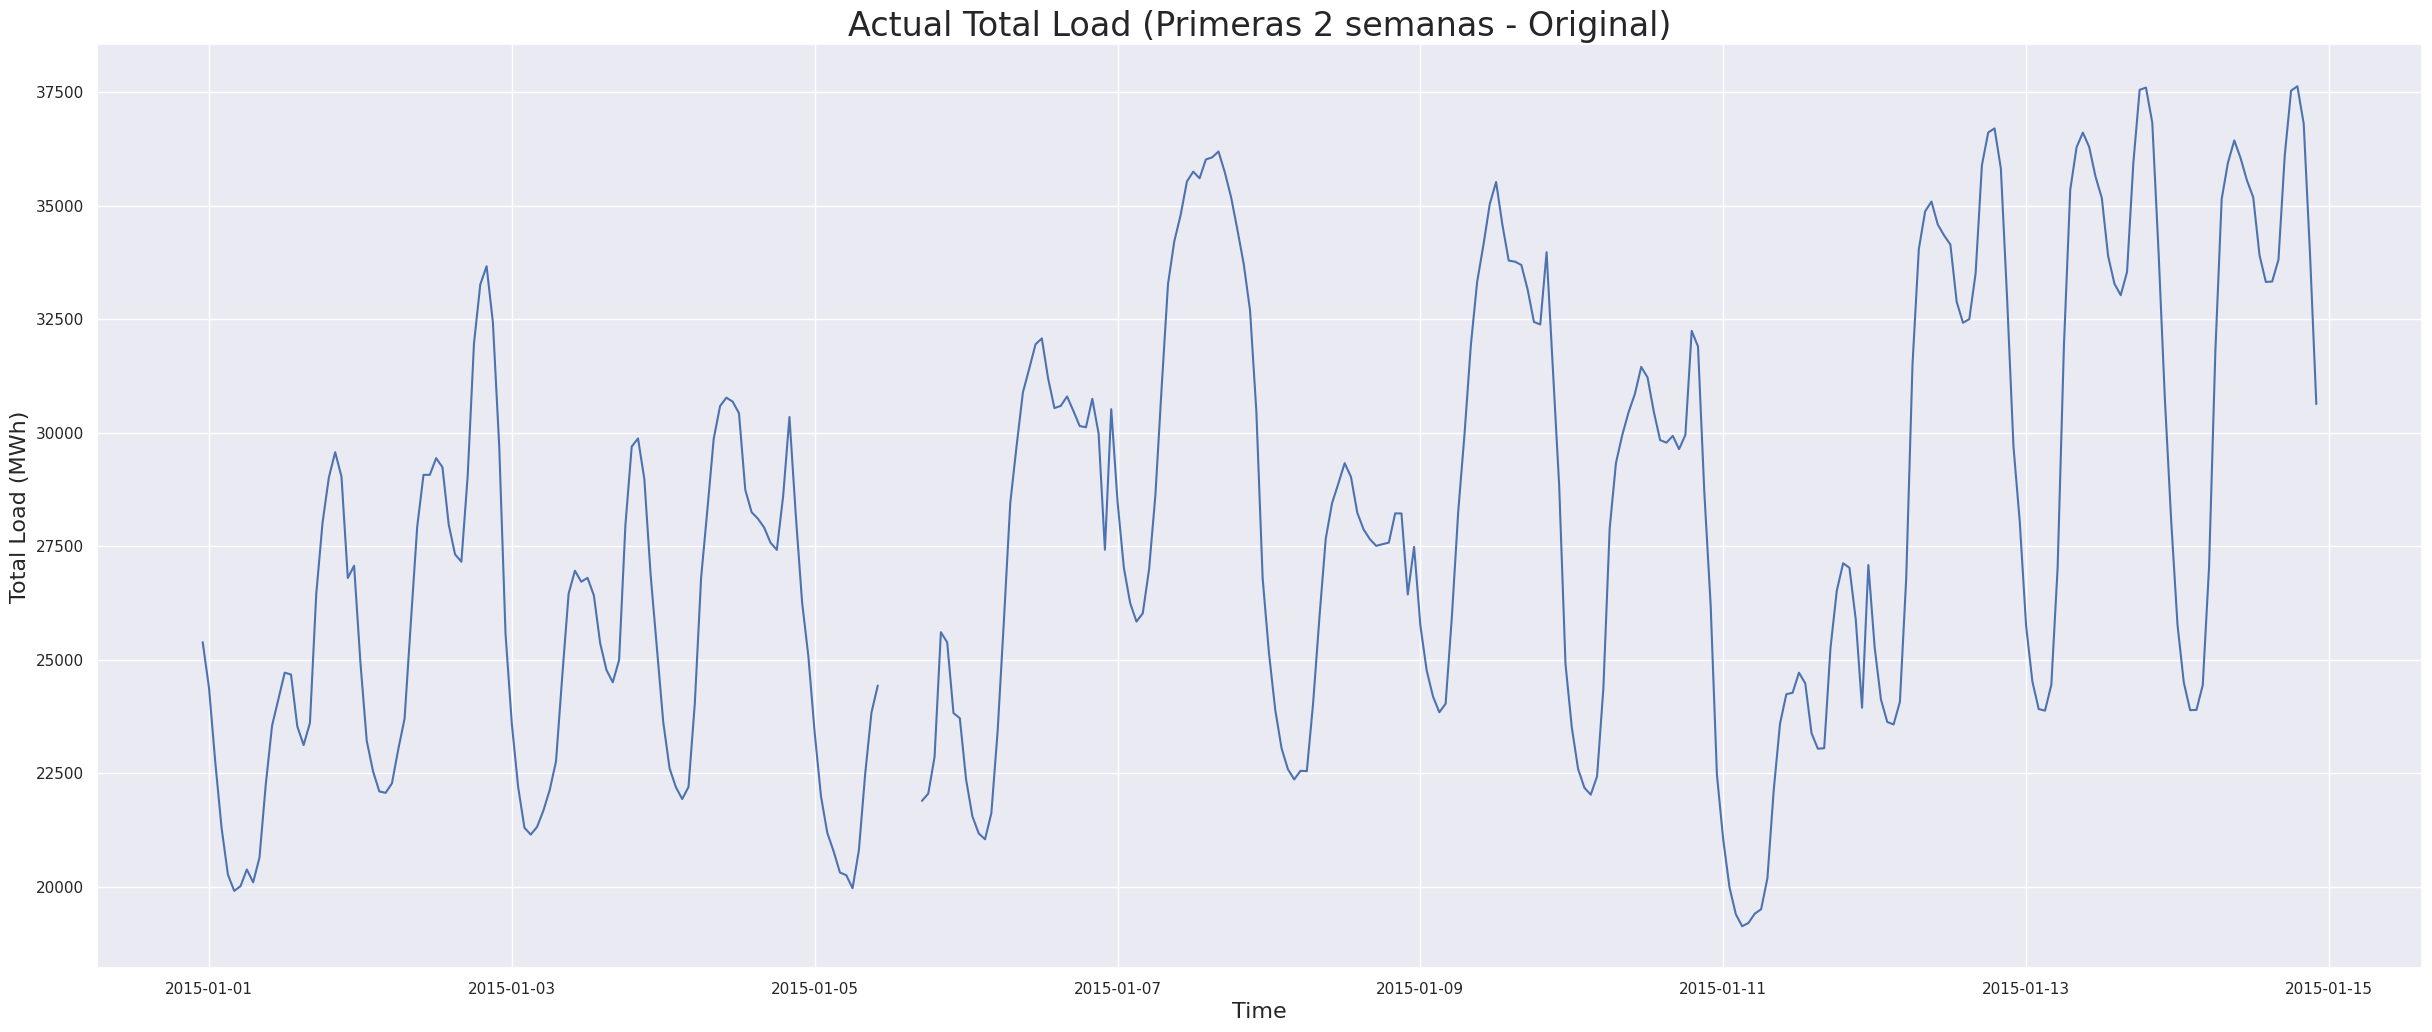

In [18]:
# Zoom al gráfico de la carga total (real) por hora

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (Primeras 2 semanas - Original)', end=24*7*2)
plt.show()

Después de acercarnos a las primeras 2 semanas de la columna 'total load actual', ya podemos ver que hay valores nulos para algunas horas. Sin embargo, el número de los valores faltantes y el comportamiento de la serie indican que una interpolación llenaría los NaNs bastante bien. Investiguemos más a fondo si los valores nulos coinciden en las diferentes columnas. Mostremos las últimas cinco filas.

In [19]:
# Llenar los NaNs con interpolacion

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [20]:
# Desplegar las filas con valores nulos

df_energy[df_energy.isnull().any(axis=1)].tail()

Empty DataFrame
Columns: [generation biomass, generation fossil brown coal/lignite, generation fossil gas, generation fossil hard coal, generation fossil oil, generation hydro pumped storage consumption, generation hydro run-of-river and poundage, generation hydro water reservoir, generation nuclear, generation other, generation other renewable, generation solar, generation waste, generation wind onshore, total load actual, price day ahead, price actual]
Index: []


Parece que **df_energy** ha sido limpiado con éxito y está listo para su uso posterior como entrada en nuestro modelo. Los 1-4 ceros en las columnas que tienen que ver con la generación de energía por tipo no deberían preocuparnos mucho. El 'consumo de almacenamiento de energía hidroeléctrica bombeada' puede parecer sospechoso, pero debemos tener en cuenta que este tipo de energía solo se utiliza para el equilibrio de carga, siendo consumido cuando hay demandas de energía pico.

DESPUES DE INTERPOLACION

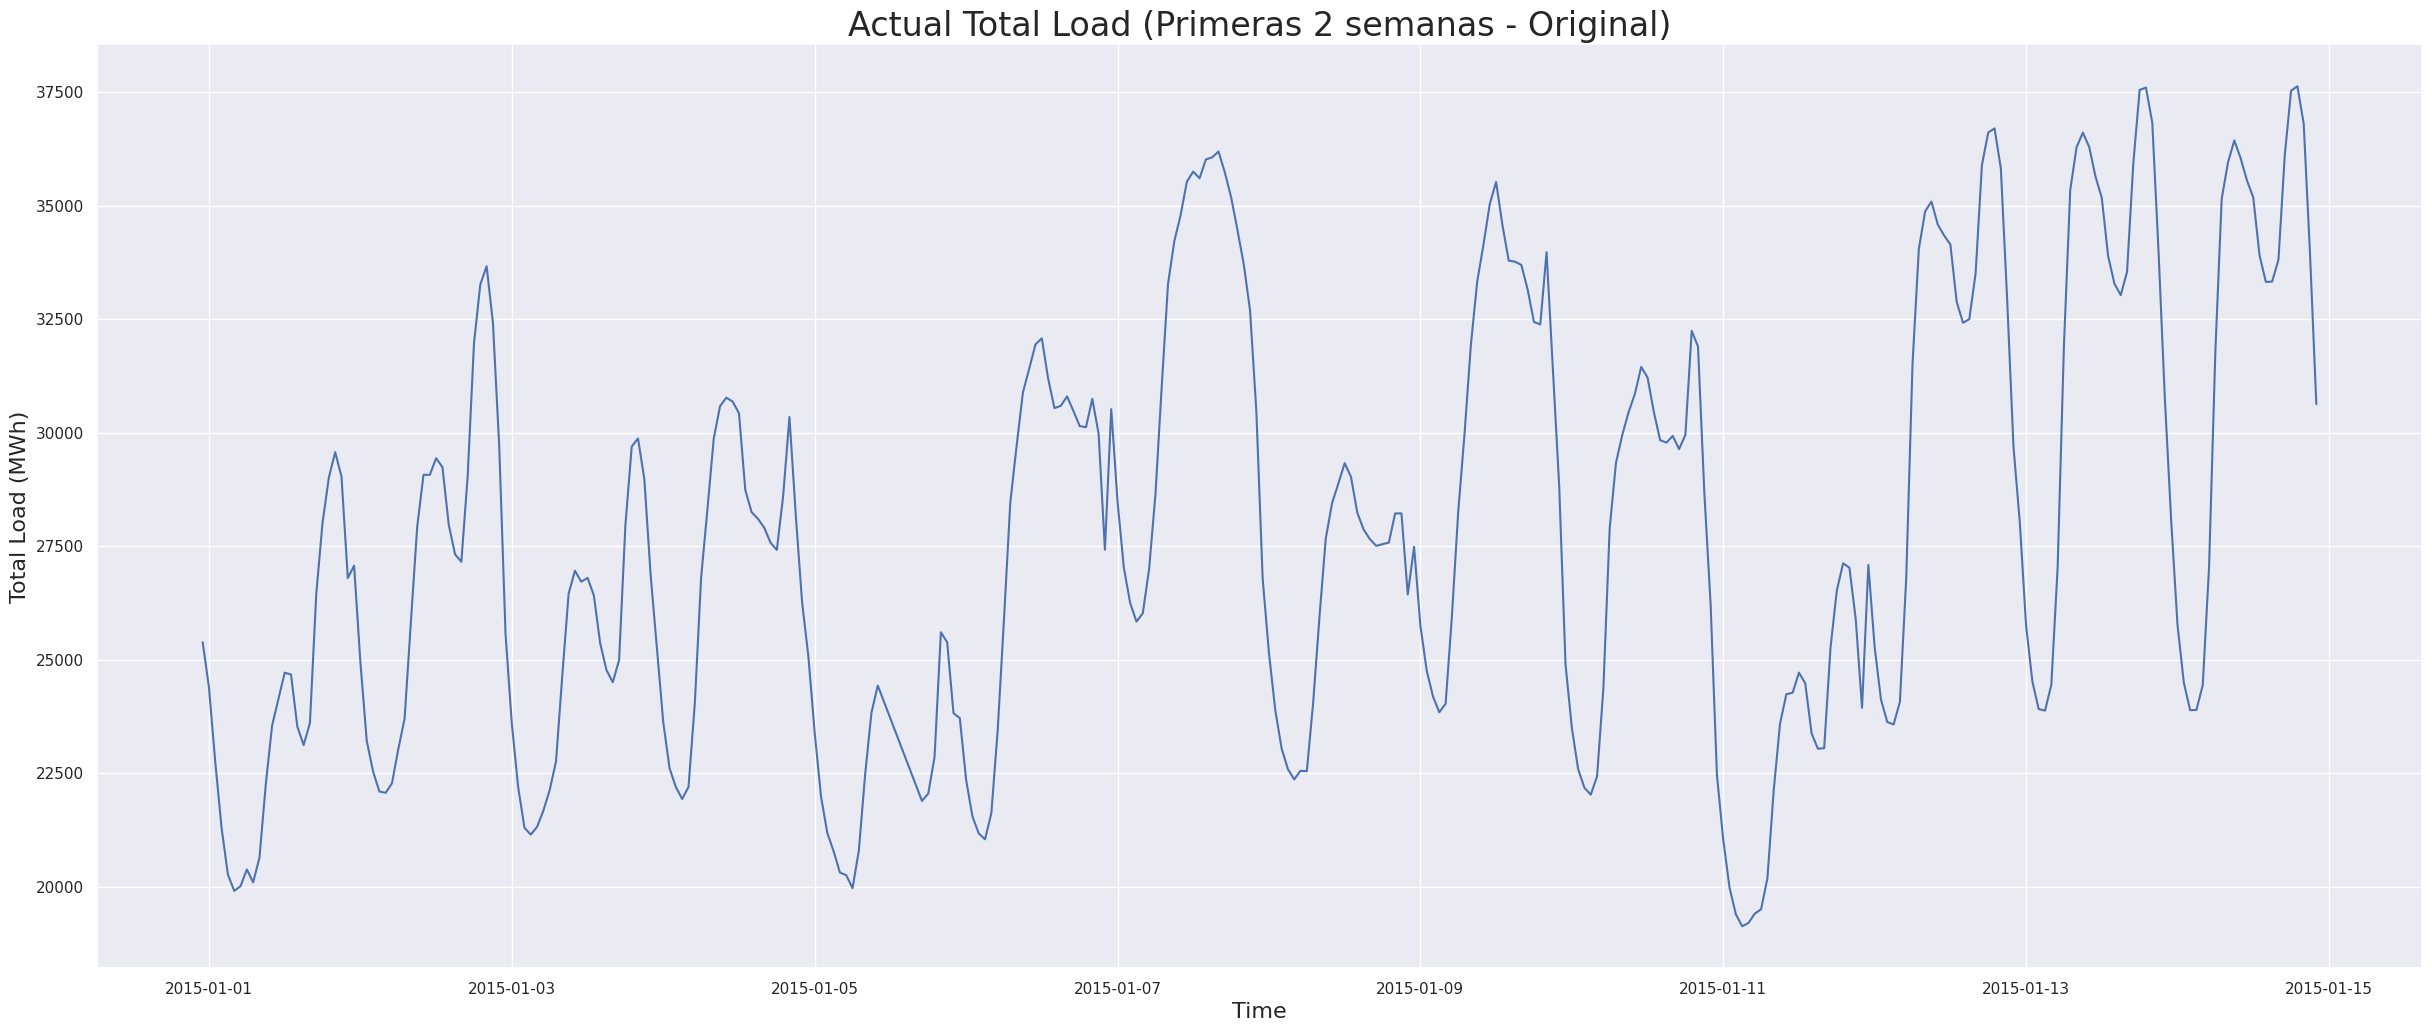

In [21]:
# Zoom al gráfico de la carga total (real) por hora

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (Primeras 2 semanas - Original)', end=24*7*2)
plt.show()

**1.2. Datos Metereologicos**

In [22]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [23]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

Aquí, podemos ver que todas las columnas de **df_weather** tienen el mismo número de filas; sin embargo, todavía tenemos que verificar cuál es el caso para cada ciudad individualmente. Debemos notar que las temperaturas están en Kelvin. Lo más importante a notar es que hay algunos problemas y valores atípicos. En particular:

Hay al menos un valor atípico en la columna **'pressure'** ya que el valor máximo es 1,008,371 hPa o aproximadamente 100 MPa, lo cual es aproximadamente la presión en el fondo de la Fosa de las Marianas, unos 11 km por debajo de la superficie del océano [2]. Esto no puede ser el caso aquí.

Hay al menos un valor atípico en la columna **'wind_speed'** ya que el valor máximo es 133 m/s. Esta medición está cerca de la velocidad del viento más rápida jamás registrada en la Tierra, causada por el tornado Bridge Creek–Moore de 1999 [3], un tornado F5 (la intensidad más grande de la escala de Fujita) [4]. Un tornado de tal intensidad no ha sido registrado en España [5] y esperemos que no ocurra en el futuro también.

La columna **'rain_3h'** se supone que proporciona información sobre la precipitación (es decir, lluvia) de las últimas 3 horas en mm. Dado que la columna **'rain_1h' **se supone que proporciona la misma información pero solo sobre la última hora, sería lógico asumir que su media sería menor que la de 'rain_3h'. Sin embargo, este no es el caso en la descripción estadística anterior. Por lo tanto, sería una buena idea examinar más a fondo esas columnas.

In [24]:
# Imprimir el tipo de cada variable en df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [25]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [26]:
# Convertir columnas con int64 a float64

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [27]:
# Convertir dt_iso a datetime

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

Tenemos que dividir el conjunto de datos **df_weather** en 5 conjuntos de datos, uno para cada ciudad diferente **(Madrid, Barcelona, Bilbao, Sevilla y Valencia).** Pero primero, veamos los valores promedio para cada columna, agrupados por cada ciudad (nota que el promedio de **'weather_id'** no tiene ningún significado en absoluto).

In [28]:
# mean_weather_by_city = df_weather.groupby('city_name').mean().select_dtypes(include=np.number)

numeric_df_weather = df_weather[['city_name'] + df_weather.select_dtypes(include=np.number).columns.tolist()]
mean_weather_by_city = numeric_df_weather.groupby('city_name').mean()

mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [29]:
# Encontrar NaNs y duplicados en df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


Parece que **df_weather** tiene muchos valores duplicados. Sin embargo, el método anterior también puede mostrarnos filas que tienen exactamente los mismos valores. Esto no es lo que estamos buscando. Lo que queremos asegurar es que no haya filas de índice duplicadas, es decir, que no tengamos múltiples filas para la misma hora exacta. Por supuesto, también tenemos que asegurarnos de que estos duplicados conciernen a cada ciudad individual. Dado que **df_weather** contiene información sobre 5 ciudades diferentes, es muy útil mostrar el número de observaciones para cada una y compararlo con el tamaño de **df_energy**.

In [30]:
# Graficas el numero de filas x cada dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.



Como podemos ver, los dos dataframes (**df_energy y df_weather)** aún no pueden combinarse. Hay muchos duplicados para cada ciudad en **df_weather** y deberíamos eliminarlos y ver si su número de filas coincide.

Hacemos esto restableciendo el índice, manteniendo solo las primeras filas que tienen los mismos valores de **'time'** y **'city_name'** y luego volviendo a establecer **'time'** como el índice. Para una investigación más profunda del conjunto de datos, creamos también un segundo dataframe, **df_weather_2** en el que hacemos el mismo procedimiento, pero mantenemos solo las últimas filas que tienen los mismos valores de **'time'** y **'city_name'**.

In [31]:
# Crear df_weather_2 y borrar filas duplicadas en df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [32]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

df_weather_2 = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


La columna **'weather_icon'** es irrelevante para nuestro análisis, así que la eliminaremos. Además, las columnas **'weather_main'** y **'weather_description'** contienen aproximadamente la misma información que la columna **'weather_id'**; la información concierne a una descripción cualitativa del clima en la hora dada. Así que trabajaremos solo con una de ellas. Sin embargo, para tomar una decisión, tenemos que verificar los valores únicos así como la consistencia de cada columna.

In [33]:
# Despleguar todos los valores unicos en la columna 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [34]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [35]:
# Despleguar todos los valores unicos en la columna 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [36]:
# Despleguar todos los valores unicos en la columna 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])


Podemos ver que en términos de descripción cualitativa, la columna **'weather_main'** parece contener la información menos detallada -o "más pobre"-, mientras que **'weather_id'** y **'weather_description'** tienen información más compleja y aproximadamente el mismo número de valores únicos.

Sin embargo, también es útil **verificar la consistencia de la información en cada columna**. Dado que nuestro conjunto de datos contenía filas duplicadas y utilizamos dos métodos diferentes para limpiarlo, una muy buena manera de verificar la consistencia de los datos en estas tres columnas sería comparar los dos dataframes limpios, df_weather y df_weather_2. Para hacer esto, **empleamos la métrica R²** ("R cuadrado" o "coeficiente de determinación"), después de codificar 'weather_description' y 'weather_main' de cadenas a etiquetas numéricas.

In [37]:
# Borrar columnas con informacion metereologica cualitativa
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [38]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".



Antes de proceder al siguiente paso, es decir, **combinar df_energy y df_weather**, también queremos tratar los valores atípicos que encontramos anteriormente en **'pressure'** y **'wind_speed'**.

Visualizaremos los valores atípicos en estas columnas usando **boxplot**, cambiaremos sus valores a NaNs y luego usaremos una interpolación lineal para reemplazar sus valores.

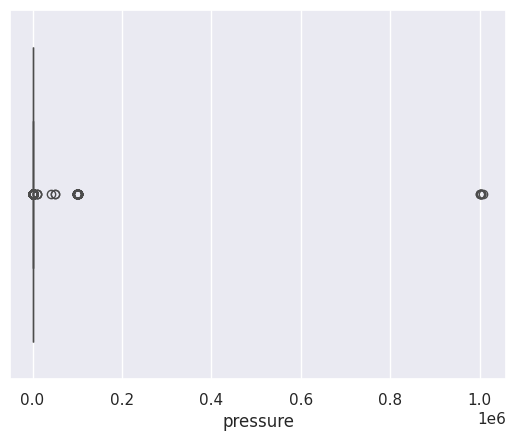

In [39]:
# Chequear x outliers en la columna 'pressure'

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [40]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


Incluso una presión de aproximadamente 100,000 HPa o 10 MPa, que es claramente visible en la figura anterior, corresponde a una cantidad mayor que la presión atmosférica de **Venus**. Para estar seguros, estableceremos como **NaN** cada valor en la columna **'pressure'** que sea **superior a 1051 hPa**, que está justo por encima de la presión atmosférica más alta jamás registrada en la península Ibérica.

Aunque los valores atípicos por el lado bajo no son visibles en el boxplot anterior, es una buena idea también reemplazar los valores que sean inferiores a 931 hPa, es decir, la presión atmosférica más baja jamás registrada en la península Ibérica.

In [41]:
# Reemplazar outliers en 'pressure' con NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan

In [42]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [43]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [44]:
# Interpolar los valores nulos

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

**1.3. Combinar datasets**

Variemos un poco el ejercicio. No solo vamos a combinar los dataframes, vamos a reemplazar las ciudades por 5 ciudades colombianas y trabajaremos el ejercicio como si fueran datos nacionales.

In [45]:
# Dividir df_weather en DataFrames separados para cada ciudad específica
df_Medellin = df_weather[df_weather['city_name'] == ' Barcelona']
df_Bogota = df_weather[df_weather['city_name'] == 'Bilbao']
df_Bucaramanga = df_weather[df_weather['city_name'] == 'Madrid']
df_Cali = df_weather[df_weather['city_name'] == 'Seville']
df_Cartagena = df_weather[df_weather['city_name'] == 'Valencia']

# Verificar que cada DataFrame contenga solo datos de su respectiva ciudad
print(f"Medellin: {df_Medellin['city_name'].unique()}")
print(f"Bogota: {df_Bogota['city_name'].unique()}")
print(f"Bucaramanga: {df_Bucaramanga['city_name'].unique()}")
print(f"Cali: {df_Cali['city_name'].unique()}")
print(f"Cartagena: {df_Cartagena['city_name'].unique()}")


Medellin: [' Barcelona']
Bogota: ['Bilbao']
Bucaramanga: ['Madrid']
Cali: ['Seville']
Cartagena: ['Valencia']


In [46]:
# Merge all dataframes into the final dataframe

# Asumiendo que df_energy ya está definido y quieres combinarlo con los datos meteorológicos de las ciudades

# Lista de los DataFrames de las ciudades y sus respectivos nombres
city_dfs = [
    (df_Medellin, "Medellin"),
    (df_Bogota, "Bogota"),
    (df_Bucaramanga, "Bucaramanga"),
    (df_Cali, "Cali"),
    (df_Cartagena, "Cartagena")
]

df_final = df_energy.copy()  # Crea una copia de df_energy para mantener el original intacto

for df, city_name in city_dfs:
    # Añade un sufijo a cada columna del DataFrame de la ciudad, excepto 'time' y 'city_name'
    df_city = df.drop(columns=['city_name']).add_suffix(f'_{city_name}')

    # Fusiona el DataFrame de la ciudad con df_final basado en la columna 'time'
    df_final = df_final.merge(df_city, on='time', how='outer')

# Verifica las columnas del DataFrame final
print(df_final.columns)


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Medellin', 'temp_min_Medellin',
       'temp_max_Medellin', 'pressure_Medellin', 'humidity_Medellin',
       'wind_speed_Medellin', 'wind_deg_Medellin', 'rain_1h_Medellin',
       'rain_3h_Medellin', 'snow_3h_Medellin', 'clouds_all_Medellin',
       'temp_Bogota', 'temp_min_Bogota', 'temp_max_Bogota', 'pressure_Bogota',
       'humidity_Bogota', 'wind_speed_Bogota', 'wind_deg_Bogota',
       'rain_1h_Bogota', 'rain_3h_Bogota', 'snow_3h_Bogota',
       'clouds_all_Bog

In [47]:
print(df_final.shape)
print(df_final.columns)

(35064, 72)
Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Medellin', 'temp_min_Medellin',
       'temp_max_Medellin', 'pressure_Medellin', 'humidity_Medellin',
       'wind_speed_Medellin', 'wind_deg_Medellin', 'rain_1h_Medellin',
       'rain_3h_Medellin', 'snow_3h_Medellin', 'clouds_all_Medellin',
       'temp_Bogota', 'temp_min_Bogota', 'temp_max_Bogota', 'pressure_Bogota',
       'humidity_Bogota', 'wind_speed_Bogota', 'wind_deg_Bogota',
       'rain_1h_Bogota', 'rain_3h_Bogota', 'snow_3h_Bogota',
       'cl

In [48]:
# Muestre el numero de NaNs y duplicados en el dataframe final

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


# 2. VISUALIZACIONES Y ANALISIS DE SERIES DE TIEMPO

**2.1. Algunos tipos de visualización**

Antes que nada, revisaremos las columnas **'rain_1h' y 'rain_3h'** para una ciudad específica.

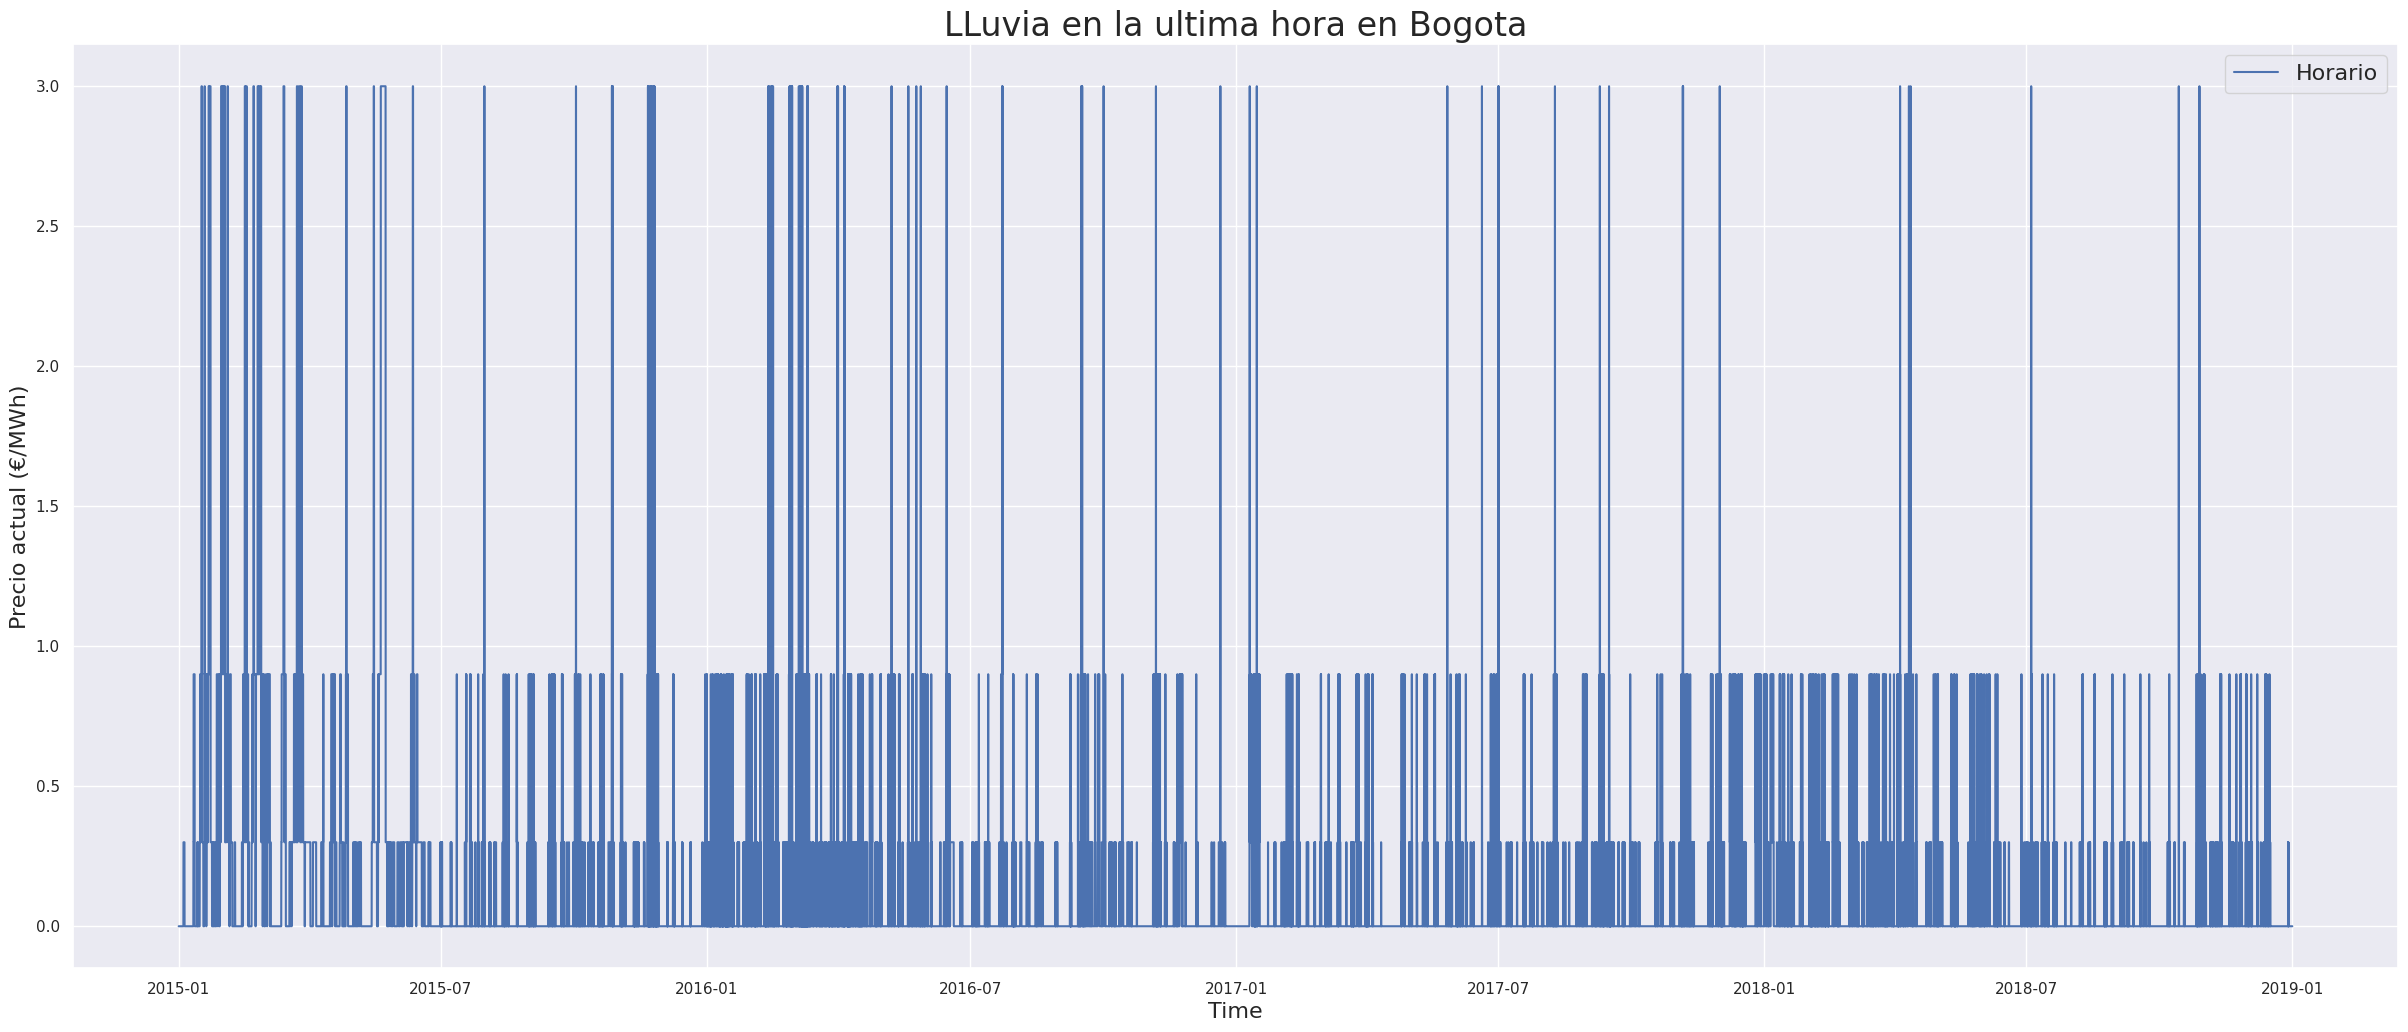

In [49]:
 # Grafiquemos 'rain_1h' para Bogota

ax = plot_series(df_final, 'rain_1h_Bogota',
                 label='Horario', ylabel='Precio actual (€/MWh)',
                 title='LLuvia en la ultima hora en Bogota')
plt.show()

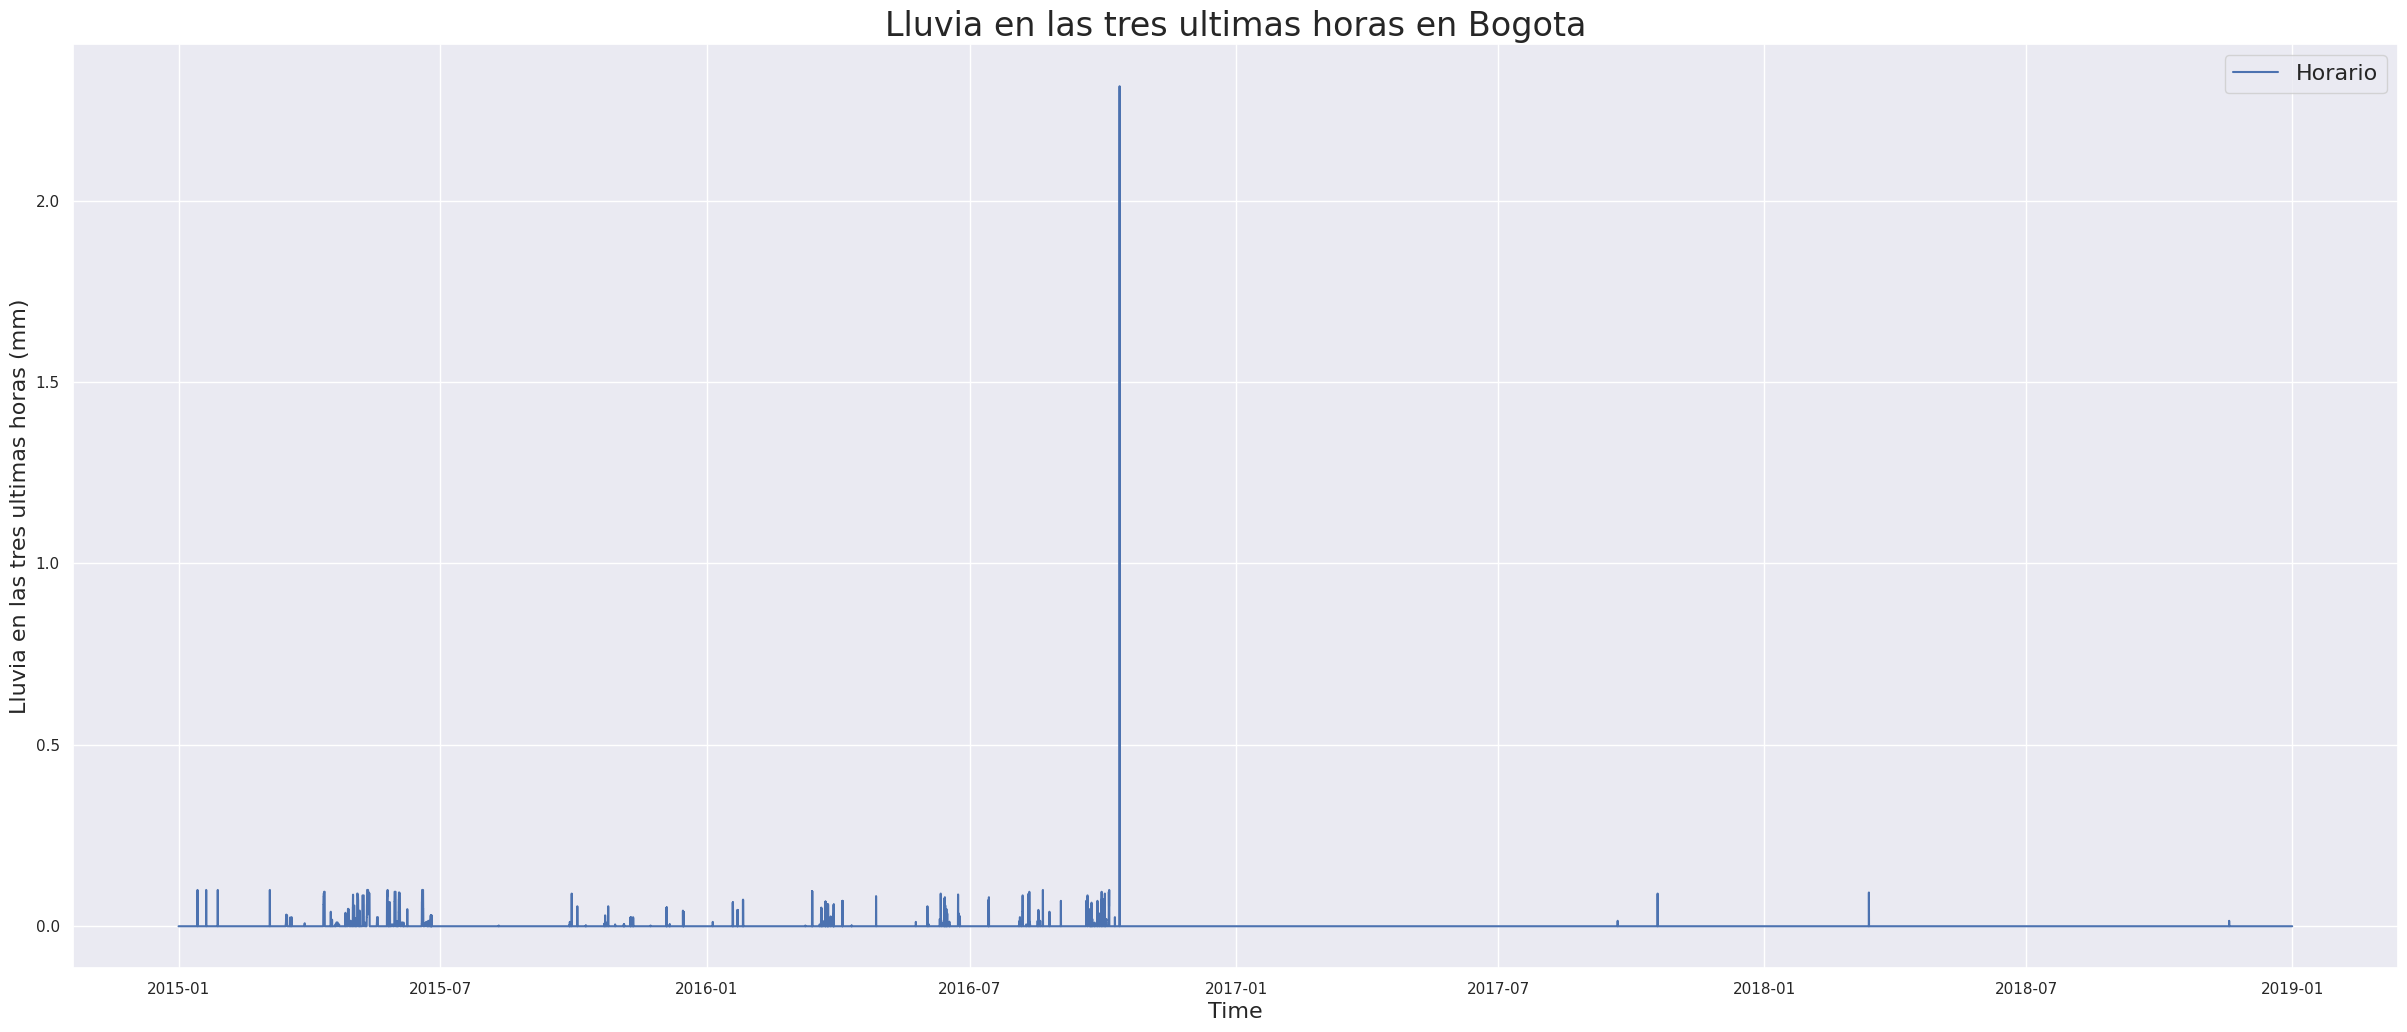

In [50]:
# Grafiquemos 'rain_3h' para Bogota

ax = plot_series(df_final, 'rain_3h_Bogota',
                 label='Horario', ylabel='Lluvia en las tres ultimas horas (mm)',
                 title='Lluvia en las tres ultimas horas en Bogota')
plt.show()

Podemos ver que la caracteristica **3 horas de lluvia** no es representativa, asi que la vamos a eliminar de los datos.

In [51]:
cities = ['Medellin', 'Bogota', 'Bucaramanga', 'Cali', 'Cartagena']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

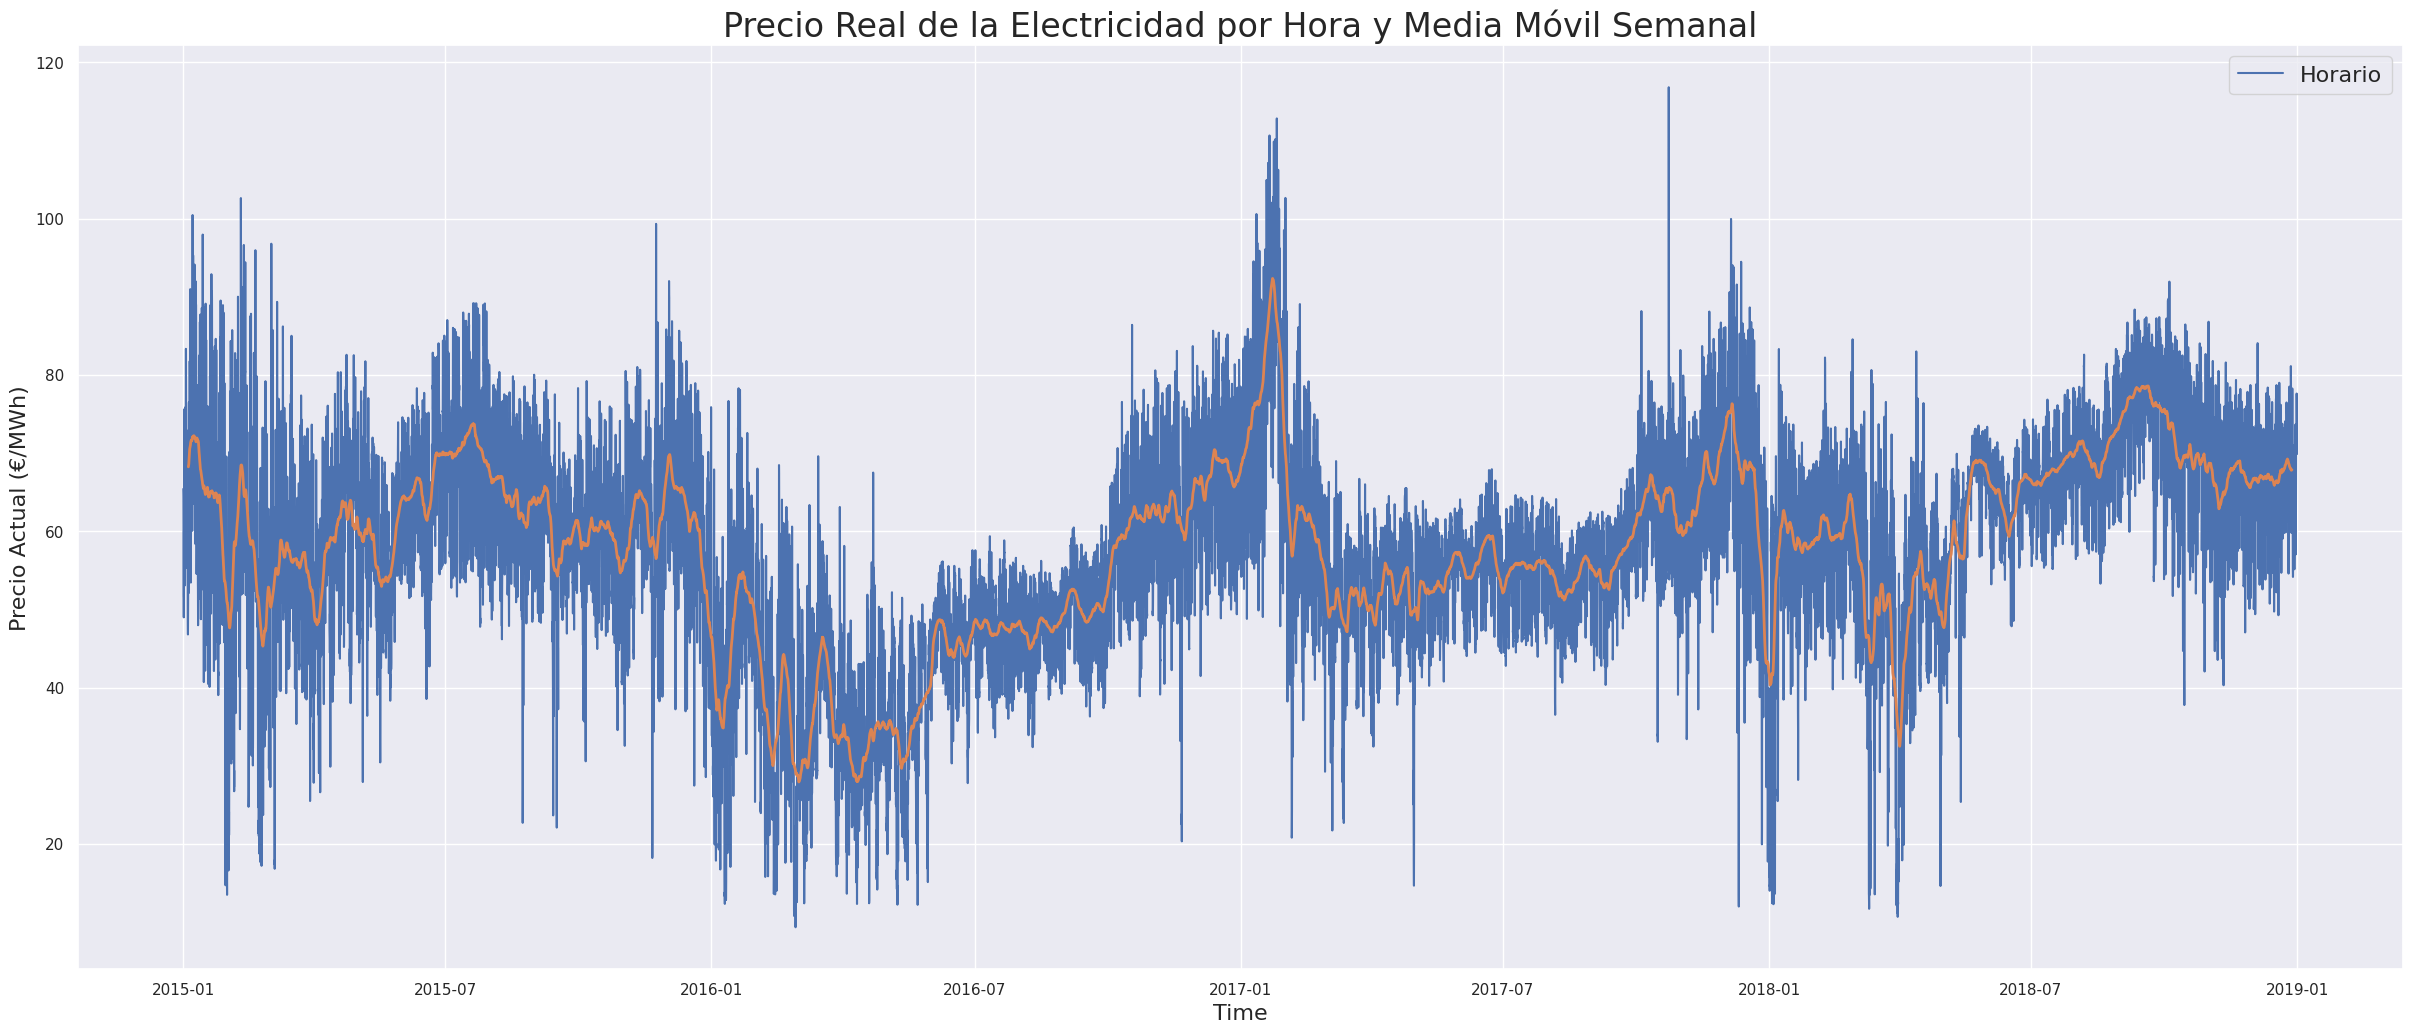

In [52]:
# Grafica el precio real de la electricidad por hora, junto con la media móvil semanal

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Horario', ylabel='Precio Actual (€/MWh)',
                 title='Precio Real de la Electricidad por Hora y Media Móvil Semanal')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

**rolling(24*7, center=True):** Aplica la función de **rolling (deslizamiento)** para calcular la media móvil. El argumento 24*7 indica el tamaño de la ventana de 168 horas (24 horas * 7 días), lo que significa que se calcula la media de una semana.

**center=True** indica que la ventana estará centrada en el tiempo actual, es decir, toma datos tanto del pasado como del futuro respecto al punto actual para calcular la media.

**.mean():** Calcula la media de los valores dentro de la ventana especificada para cada punto, resultando en la serie rolling que representa la media móvil semanal del precio de la electricidad.

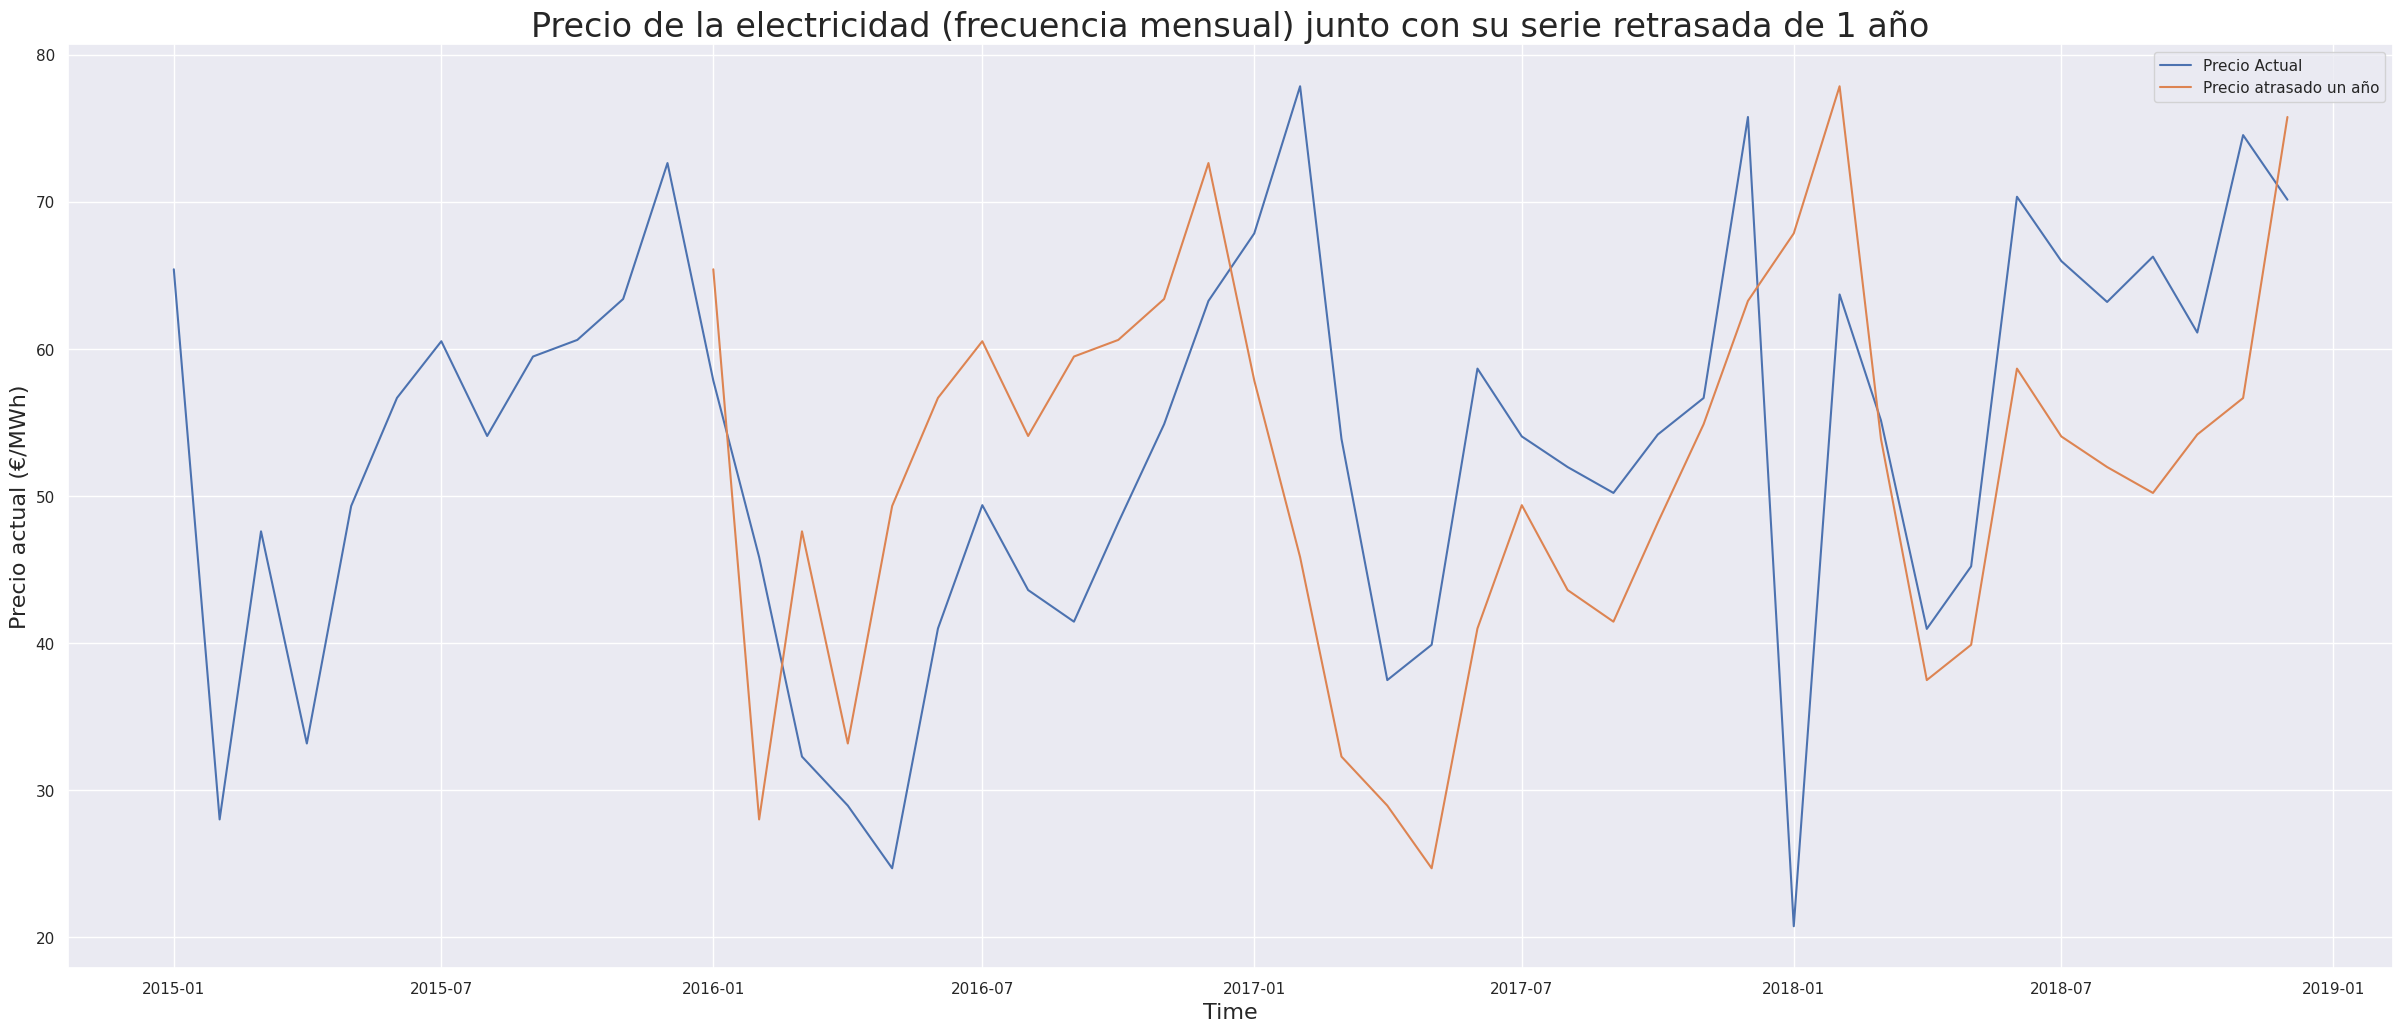

In [53]:
# Grafiquemos el precio de la electricidad (monthly frequence) junto con su serie retrasada de 1 año

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Precio actual (€/MWh)',
                 title='Precio de la electricidad (frecuencia mensual) junto con su serie retrasada de 1 año')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Precio Actual', 'Precio atrasado un año'])
plt.show()

La figura anterior muestra la **frecuencia mensual (remuestreada) del precio real de la electricidad, junto con su frecuencia mensual retrasada de 1 año**.

Podemos ver que  hay patrones estacionales a escala mensual, ya que ciertos "picos" en la serie temporal ocurren exactamente en los mismos meses. Esto significa que sería una buena idea crear una nueva característica para los meses.

**1. Identificar Patrones Estacionales**

**2. Mejorar la Comprensión de la Dinámica Temporal**

**3. Desarrollo de Características para Modelos Predictivos**

**4. Evaluación de la Autocorrelación**

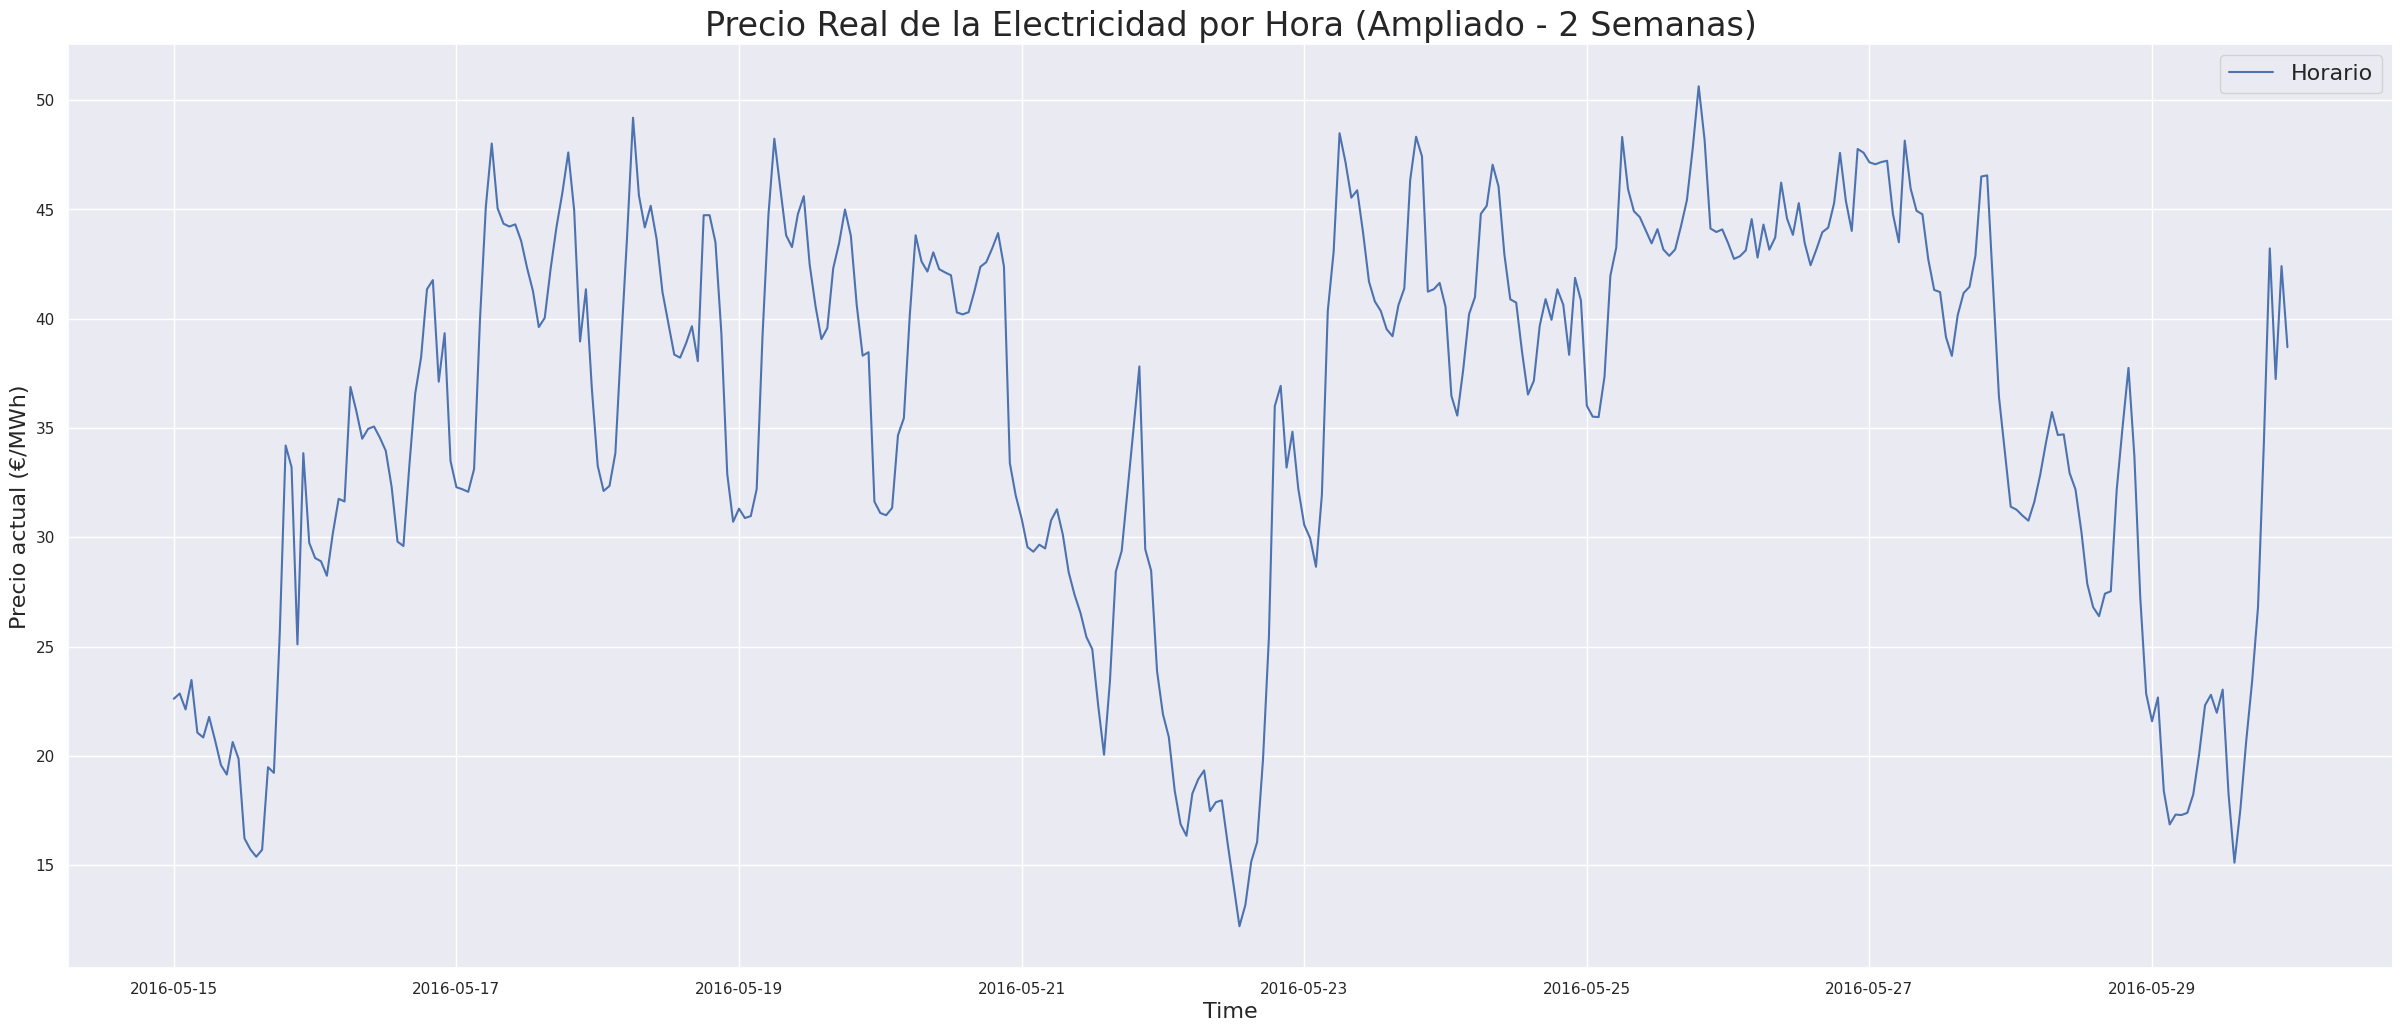

In [54]:
# Grafica el precio real de la electricidad a una escala diaria/semanal

ax = plot_series(df_final, 'price actual', label='Horario', ylabel='Precio actual (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Precio Real de la Electricidad por Hora (Ampliado - 2 Semanas)')
plt.show()

En la figura anterior, hemos graficado el **precio real de la electricidad por hora desde el 15/06/2016 (domingo) a las 00:00 hasta el 29/06/2016 (domingo) a las 23:00**, es decir, dos semanas de datos. Podemos observar que hay muchos patrones y periodicidades, tales como:

**Una periodicidad de semana a semana**, ya que el precio de la electricidad tiende a ser más alto durante los días laborables y más bajo durante los fines de semana y especialmente durante los domingos.

**Una periodicidad intradiaria,** ya que el precio es más alto durante el día y más bajo durante la noche.

**Una periodicidad dentro del horario laboral,** ya que en algunos casos el precio de la electricidad cae por unas horas, lo cual probablemente se debe a la "siesta", el descanso tradicional para el almuerzo entre la 01:30 p.m. y las 04:30 p.m., ya que España no sigue estrictamente el día laboral de 9 a.m. a 5 p.m.

Más adelante, nos aseguraremos de generar características que contengan este tipo de información.

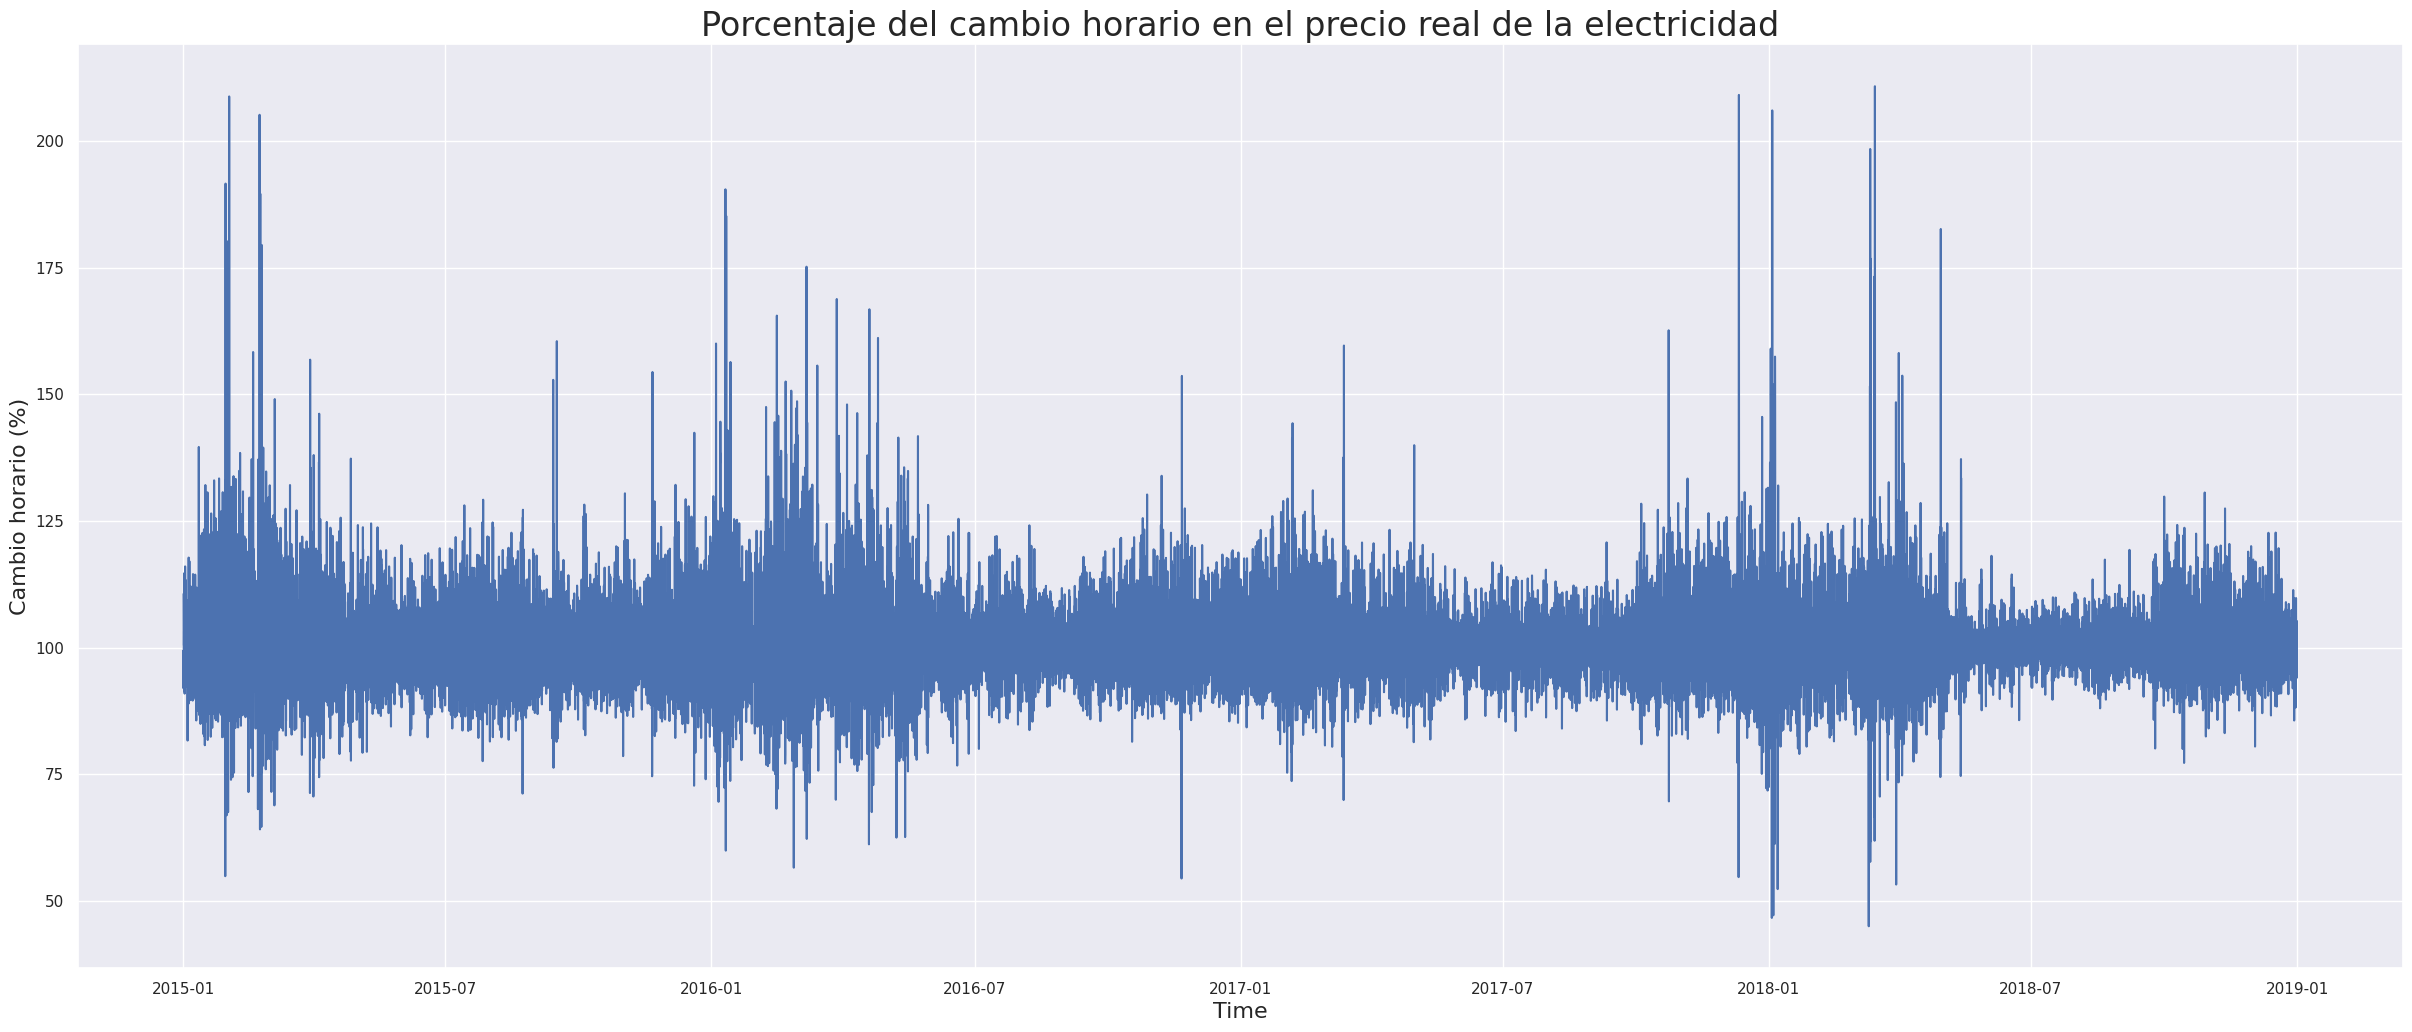

In [55]:
 # Grafica el porcentaje del cambio horario en el precio actual de la electricidad

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Cambio horario (%)',
                 title='Porcentaje del cambio horario en el precio real de la electricidad')
plt.show()


Podemos ver que el cambio en el precio real de hora en hora, en la mayoría de los casos, está entre -25% (precio actual * 0.75) y +25% (precio actual * 1.25). Sin embargo, también hay muy pocos valores atípicos que muestran que el precio se reduce a la mitad (-50%) o se duplica (+100%).


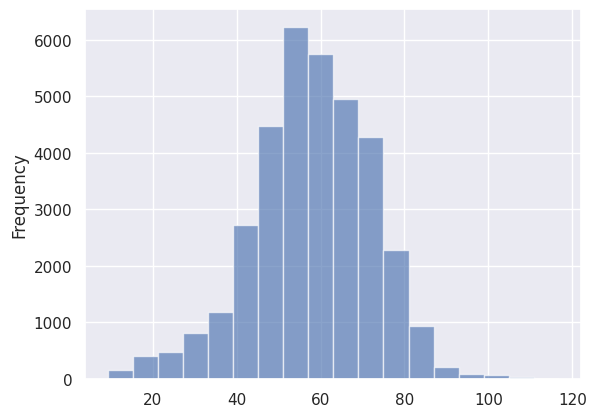

In [56]:
# Grafiquemos el histograma del precio actual de la electricidad

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

Vemos que el precio real de la energía sigue aproximadamente una distribución normal y, por lo tanto, podría ser estandarizado. Sin embargo, también tenemos que asegurarnos de que la serie temporal no requiera ningún otro tipo de transformaciones. Más específicamente, verificaremos si la serie temporal del precio de la energía es estacionaria, después de visualizar sus componentes descompuestos en series temporales.

# **2.2. Decomposicion y pruebas estacionarias**

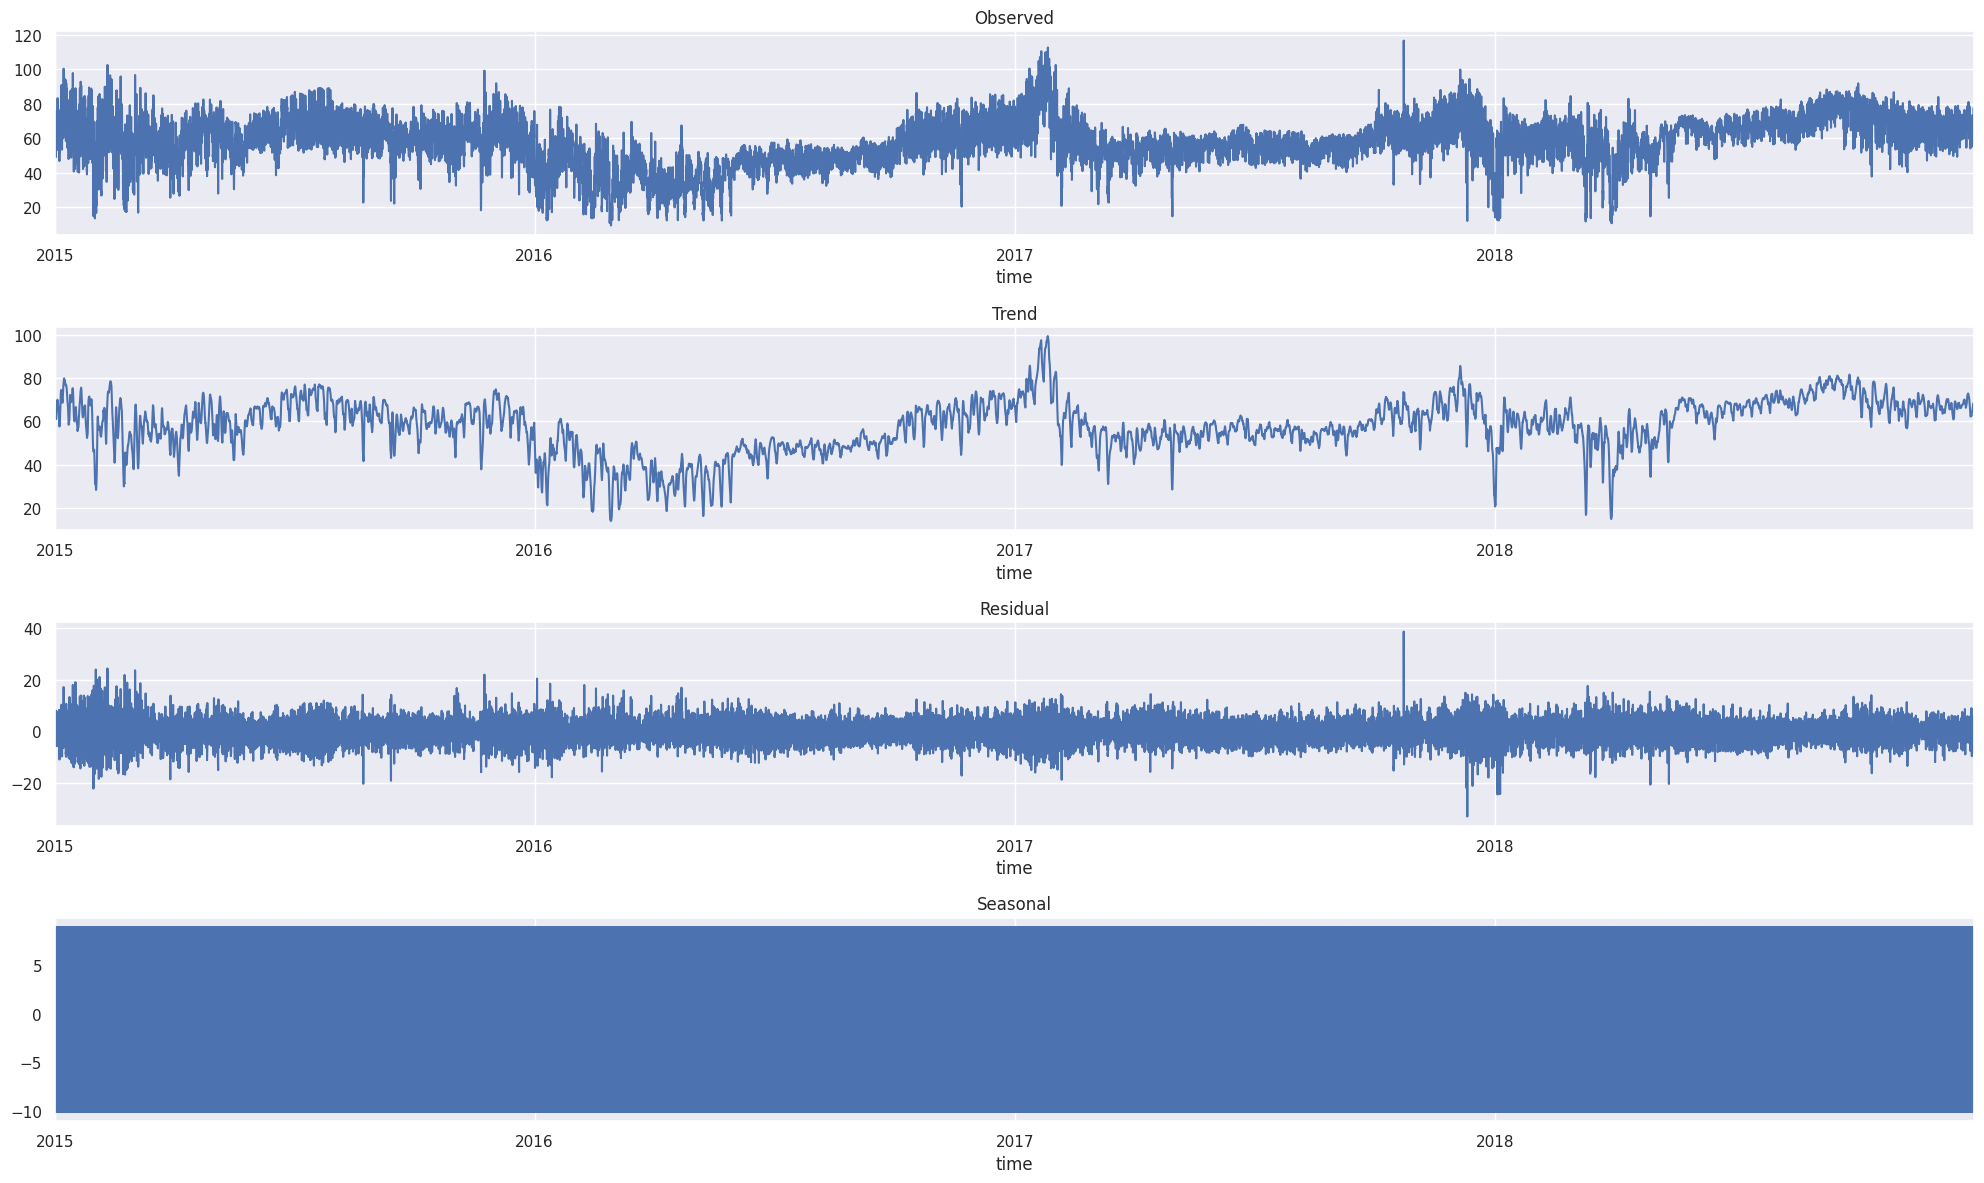

In [57]:
# Descomponer la serie temporal del precio de la electricidad

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

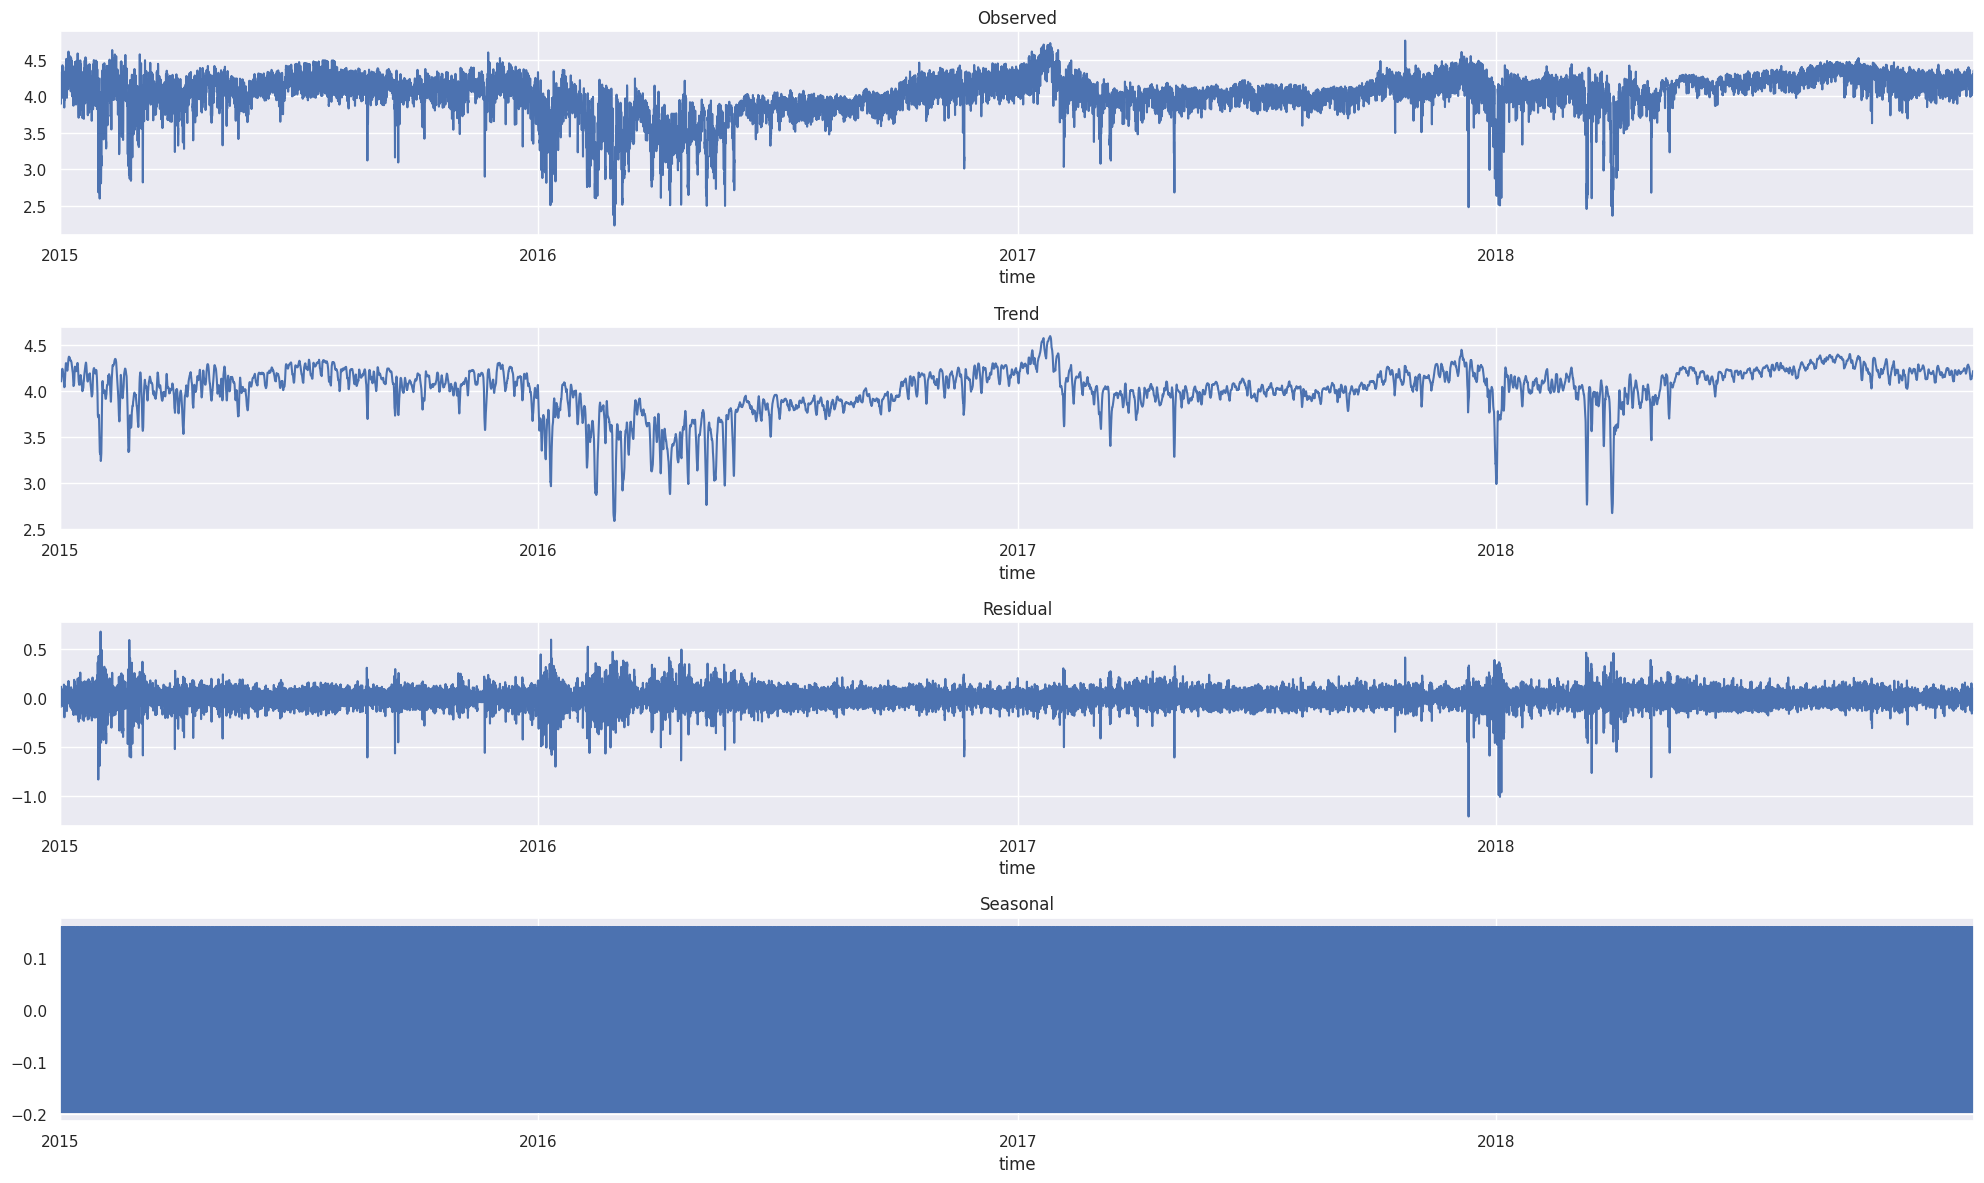

In [58]:
# Descomponer la serie temporal del registro del precio de la electricidad

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

**La prueba de Dickey-Fuller Aumentada (ADF),** un tipo de prueba de raíz unitaria, determina cuán fuertemente una serie temporal está definida por una tendencia. Sus hipótesis son las siguientes:

**Hipótesis Nula 𝐻0:** Hay una raíz unitaria en la serie temporal, es decir, la serie está autocorrelacionada con (r=1), una estructura dependiente del tiempo y, por lo tanto, no es estacionaria.

**Hipótesis Alternativa 𝐻1:** La serie temporal no tiene raíz unitaria y es estacionaria o puede hacerse estacionaria mediante diferenciación.

In [59]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814



**La estadística ADF (-9.147)** es **menor que el valor crítico al 1% (-3.431)** y, por lo tanto,**podemos decir que rechazamos la hipótesis nula 𝐻0 con un nivel de significancia del 1%,** lo que **significa** que no hay una raíz-unitaria en la serie temporal y, por lo tanto, que **es estacionaria o podría hacerse estacionaria con diferenciación de primer orden** (diferencia-estacionaria).

**La prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS),** sigue la lógica opuesta a la prueba de Dickey-Fuller Aumentada y verifica la estacionariedad. Sus hipótesis son las siguientes:

**Hipótesis Nula 𝐻0:** La serie temporal es de nivel, es decir, es estacionaria alrededor de una constante.

**Hipótesis Alternativa 𝐻1:** Hay una raíz unitaria en la serie temporal y por lo tanto no es estacionaria.

In [60]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


La estadística **KPSS (7.957)** es **mayor que** el **valor crítico al 1% (0.739)** y, por lo tanto, **podemos decir** que no podemos rechazar la hipótesis nula 𝐻0 con un nivel de significancia del 1%, lo que significa **que la serie temporal es estacionaria** o estacionaria alrededor de una constante.

# Ambas pruebas concluyeron que la serie temporal del precio de la electricidad es estacionaria.

**También es cierto que las redes neuronales profundas pueden manejar tales propiedades de una manera más indulgente en comparación con los modelos ARIMA.**

# **2.3. Autocorrelacion, Crosscorrelacion y correlacion parcial**

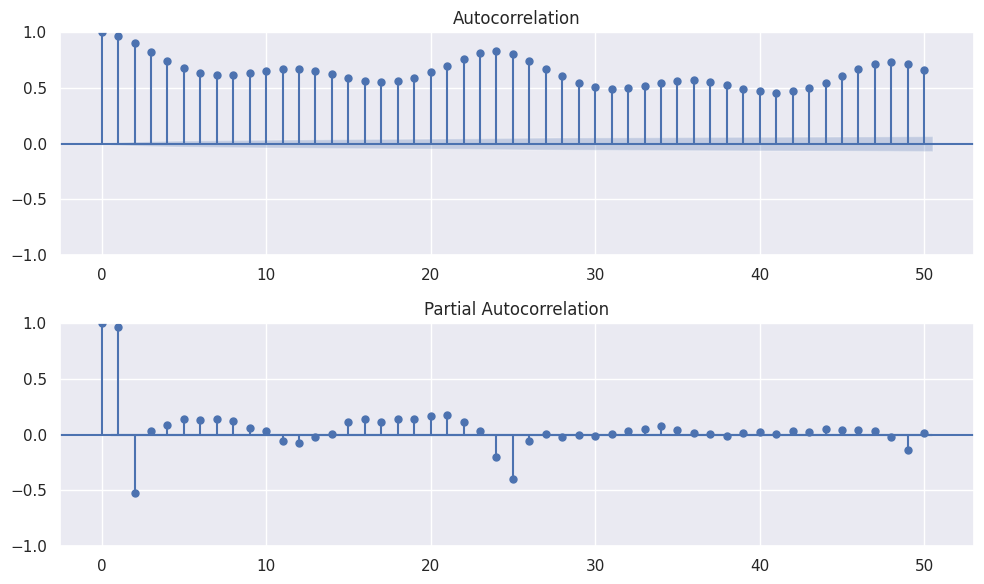

In [61]:
# Grafiquemos la autocorrelacion y la correlacion parcial de los datos

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

**La gráfica de autocorrelación parcial** de la serie temporal del precio de la electricidad **muestra que la relación directa entre una observación en una hora dada (t) es más fuerte con las observaciones en los pasos de tiempo t-1, t-2, t-24 y t-25 y disminuye después.** Por lo tanto, **vamos a utilizar los 25 valores anteriores de cada serie temporal que constituirán una característica para nuestros modelos.**

Sin embargo, definitivamente **sería más beneficioso si solo eligiéramos usar valores pasados específicos** (observaciones en ciertos retrasos temporales) de una característica dada, basados en la correlación cruzada entre el precio de la electricidad y cada una de las características en el conjunto de datos. Por ejemplo, **a continuación, podemos ver la correlación cruzada entre el precio de la electricidad y la carga total.** Vemos que hay muchos retrasos temporales con una correlación que está cerca de cero y podrían ser omitidos.

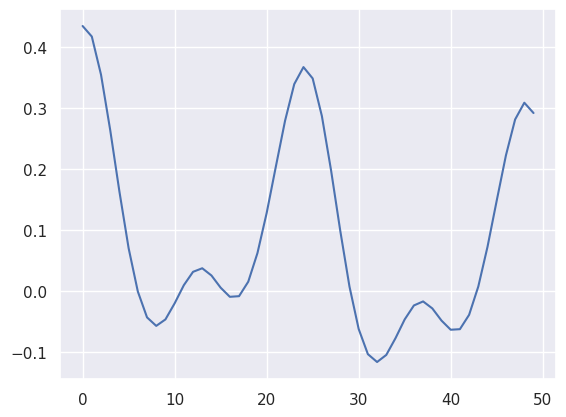

In [62]:
# Correlacion cruzada o crosscorrelacion
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

In [63]:
# Encontremos las correlacoines entre el precio de la energia y el resto de features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Bogota                                0.194063
generation waste                               0.168710
pressure_Medellin                              0.167847
generation biomass                             0.142671
temp_min_Cartagena                             0.133141
pressure_Cartagena                             0.109812
temp_min_Medellin                              0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Bucaramanga                           0

A partir de lo anterior, ya podemos ver algunas correlaciones muy interesantes entre el precio de la energía que queremos predecir y el resto de las características.

Por ejemplo, **la carga total de energía y la cantidad de energía generada a partir de fuentes relacionadas con combustibles fósiles, está positivamente correlacionada con el precio de la electricidad.** En contraste, **la velocidad del viento en casi todas las ciudades y la cantidad de energía de almacenamiento consumida a través del bombeo hidroeléctrico está negativamente correlacionada con el precio de la energía.**

Procederemos a eliminar 'snow_3h_Medellin' y 'snow_3h_Cali', que dan NaNs en sus correlaciones con el precio real de la electricidad.

In [64]:
df_final = df_final.drop(['snow_3h_Medellin', 'snow_3h_Cali'], axis=1)

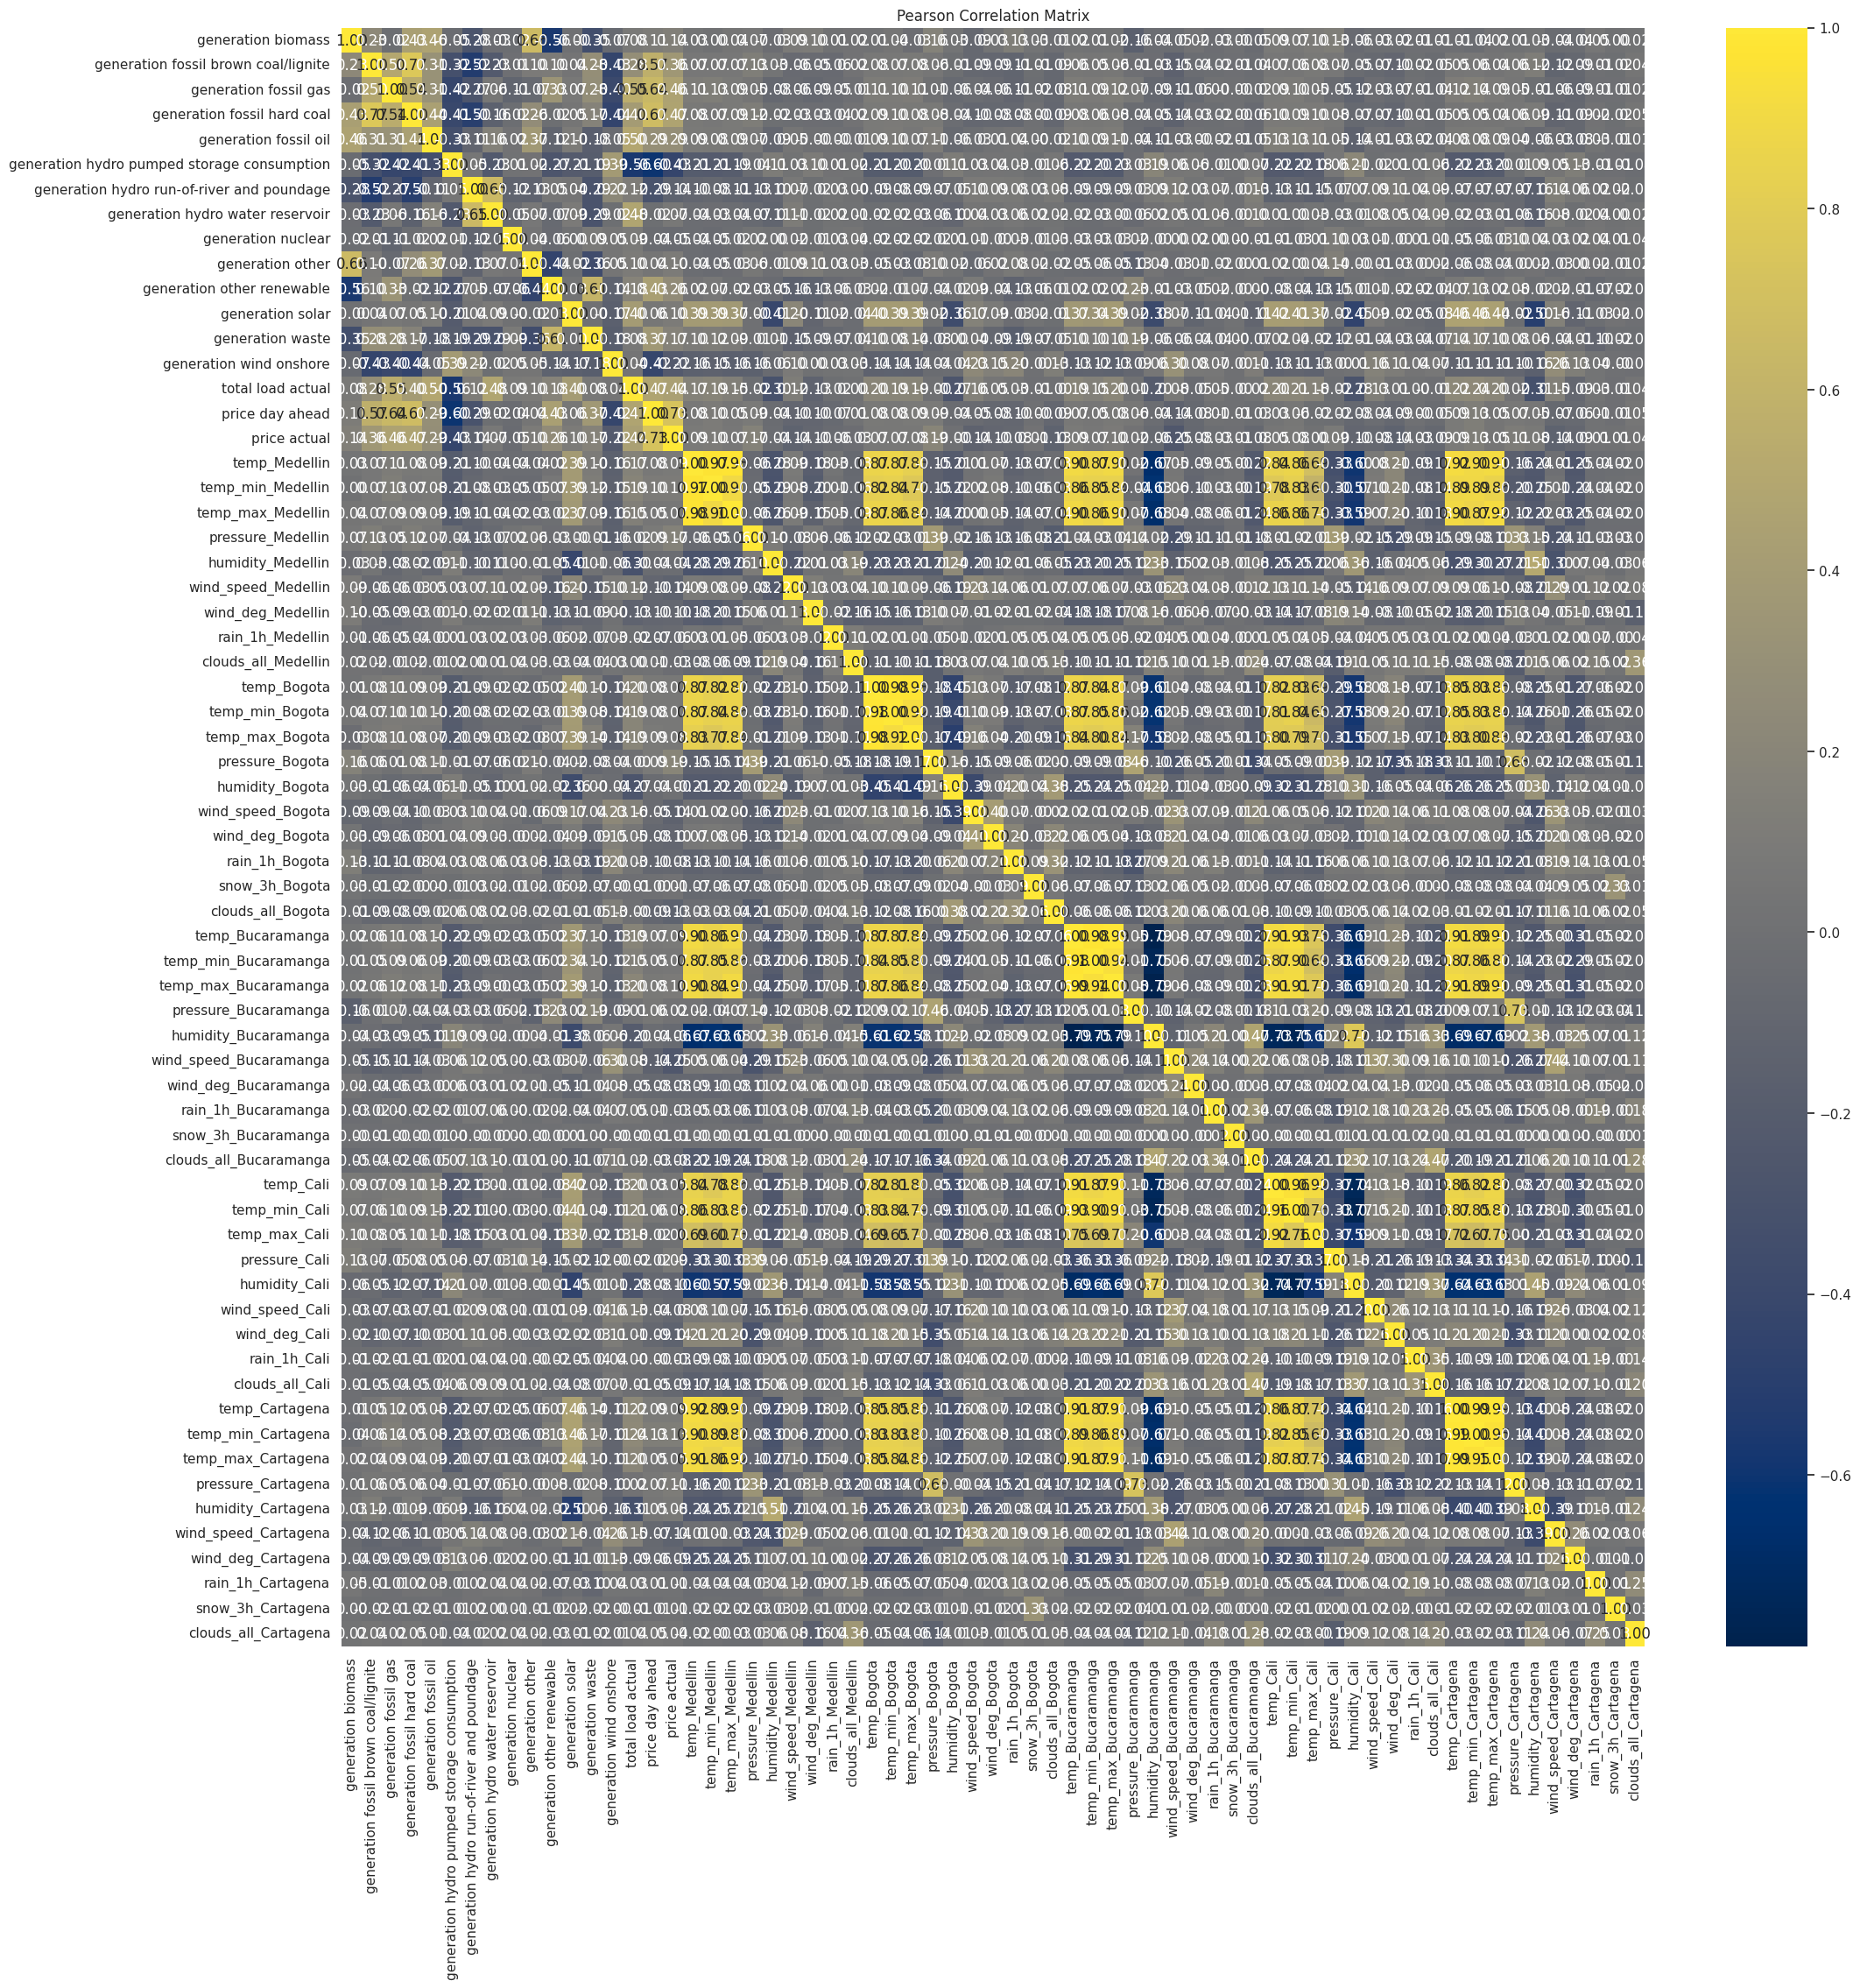

In [65]:
# Grafiquemos la correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='cividis')  # pueden usar la paleta que mas les guste
plt.title('Pearson Correlation Matrix')
plt.show()

**Nombres de algunas paletas de colores**

**viridis:** Una paleta de colores perceptualmente uniforme en tonos verdes-azulados, buena para representar datos ordenados.

**plasma: **Similar a "inferno", pero con una gama de colores que va desde el amarillo brillante hasta el morado oscuro.

**magma:** Una paleta que va desde el negro a través de tonos de rojo y naranja hasta amarillo brillante.

**cividis:** Otra paleta perceptualmente uniforme, optimizada para ser claramente visible a personas con daltonismo.

**coolwarm:** Una paleta divergente que va del azul frío al rojo cálido, útil para datos con un punto medio claro.

**Spectral: **Paleta divergente con una amplia gama de colores, desde el rojo hasta el azul, pasando por tonos de naranja, amarillo y verde.

**RdYlBu:** Abreviatura de Rojo-Amarillo-Azul, otra paleta divergente popular para destacar diferencias en los datos.

**RdYlGn: **Abreviatura de Rojo-Amarillo-Verde, similar a RdYlBu pero utiliza verde en lugar de azul para el extremo inferior.

**Blues:** Una paleta secuencial que va de colores azules claros a oscuros, ideal para resaltar la intensidad en los datos.

**Greens: **Similar a "Blues", pero en tonos de verde, desde los más claros hasta los más oscuros.

In [66]:
# usemos nuestras librerias de python para ver las mayores correlaciones
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Medellin                         temp_min_Medellin                       0.970264
                                      temp_max_Medellin                       0.976904
                                      temp_Bogota                             0.866727
                                      temp_min_Bogota                         0.867970
                                      temp_max_Bogota                         0.828347
                                      temp_Bucaramanga                        0.903996
                                      temp_min_Bucaramanga                    0.874548
                                      temp_max_Bucaramanga                    0.899010
                                      temp_Cali                               0.841910
                                      temp_

# **3. FEATURE ENGINEERING**

# **3.1. Generar caracteristicas**


Las primeras características que generaremos para una hora dada serán simplemente esa hora en particular, el día y el mes en los que ocurre.

In [67]:
# Generar 'hora', 'dia_laboral' y 'mes' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hora = position.hour
    dia_laboral = position.weekday()
    mes = position.month
    df_final.loc[position, 'hora'] = hora
    df_final.loc[position, 'dia_laboral'] = dia_laboral
    df_final.loc[position, 'mes'] = mes

Una característica muy útil que generaremos tiene que ver con el horario laboral, es decir, si los negocios están abiertos o no en una hora dada. En Colombia, el día laboral de 9 a.m. a 5 p.m. no es seguido generalmente por todos los tipos de negocios, debido a un descanso para almorzar (conocido como "almuerzo") entre medio. Las horas de negocio más usuales son de lunes a sábado, de 9:30 a.m. a 1:30 p.m. y luego nuevamente de 4:30 p.m. a 8 p.m.

Por lo tanto, el valor de la **'hora de negocio'** será igual a **'2'** si la hora dada está dentro del **horario comercial**,

igual a **'1'** si la hora dada está dentro de la **"almuerzo"** intermedia e **igual a '0' para todas las demás horas dadas.**

In [68]:
# Generar 'Hora de negocio' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hora = position.hour
    if ((hora > 8 and hora < 14) or (hora > 16 and hora < 21)):
        df_final.loc[position, 'Hora de negocio'] = 2
    elif (hora >= 14 and hora <= 16):
        df_final.loc[position, 'Hora de negocio'] = 1
    else:
        df_final.loc[position, 'Hora de negocio'] = 0


Sin embargo, hemos generado la característica **'hora de negocio'** de tal manera que también incluye los fines de semana, en los cuales hay menos -o diferentes tipos de- negocios abiertos. Por lo tanto, es útil generar también otra característica, **'fin de semana'**, que distinguirá entre días laborables y fines de semana, así como hacer una distinción entre sábados y domingos.

En particular, para una hora dada específica, **el valor de 'fin de semana' será igual a '0'**, si la hora está en un día laborable, **igual a '1' si la hora está en un sábado e igual a '2' si la hora está en un domingo.**

In [69]:
# Generar 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    dia_laboral = position.weekday()
    if (dia_laboral == 6):
        df_final.loc[position, 'dia_laboral'] = 2
    elif (dia_laboral == 5):
        df_final.loc[position, 'dia_laboral'] = 1
    else:
        df_final.loc[position, 'dia_laboral'] = 0


Para reducir la dimensionalidad y potencialmente adquirir un nuevo tipo de información, para cada hora dada, restaremos la temperatura mínima **('temp_min')** de la temperatura máxima **('temp_max') **para cada ciudad y nombraremos esa característica **'temp_range_{nombre de la ciudad}'**

In [70]:
# Generar 'temp_range' para cada ciudad

cities = ['Medellin', 'Bogota', 'Bucaramanga', 'Cali', 'Cartagena']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

Después de ver que hay una alta correlación entre las temperaturas de las diferentes ciudades, también intentaremos crear características de temperatura ponderada teniendo en cuenta la población de cada ciudad.

*   Bogota: 10,155,116
*   Medellin: 3,179,243
*   Cartagena: 1,645,342
*   Cali: 1,305,342
*   Bucaramanga: 987,000

In [71]:
# Calculemos el peso para cada ciudad

total_pop = 10155116 + 3179243 + 1645342 + 1305342 + 987000

weight_Bogota = 10155116 / total_pop
weight_Medellin = 3179243 / total_pop
weight_Cartagena = 1645342 / total_pop
weight_Cali = 1305342 / total_pop
weight_Bucaramanga = 987000 / total_pop

In [72]:
cities_weights = {'Bucaramanga': weight_Bucaramanga,
                  'Medellin': weight_Medellin,
                  'Cali': weight_Cali,
                  'Cartagena': weight_Cartagena,
                  'Bogota': weight_Bogota}

In [73]:
# Generar la característica 'temp_weighted'

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

También generaremos una nueva característica que agregue ambas fuentes de energía relacionadas con el carbón y que están altamente correlacionadas (0.7688).

In [74]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

# **DATA FRAME FINAL CARGUE**

In [75]:
df_final.to_csv('/content/drive/MyDrive/SENSORES REMOTOS/df_final.csv', index=True)

df_final = pd.read_csv('/content/drive/MyDrive/SENSORES REMOTOS/df_final.csv', skiprows = 0, index_col = 'time', parse_dates = True)

df_final.index = pd.to_datetime(df_final.index, utc=True, infer_datetime_format=True)

In [76]:
df_final.head()

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2014-12-31 23:00:00+00:00                                      1051.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 01:00:00+00:00                                       973.0   
2015-01-01 02:00:00+00:00                                       949.0   
2015-01-01 03:00:00+00:00                                       953.0   

                           generation hydro water reservoir  \
time                                                          
2014-12-31 23:00:00+00:00                            1899.0   
2015-01-01 00:00:00+00:00                            1658.0   
2015-01-01 01:00:00+00:00                            1371.0   
2015-01-01 02:00:00+00:00                             779.0   
2015-01-01 03:00:00+00:00                             720.0   

                           generation nuclear  generation other  ...  \
time                                                             ...   
2014-12-31 23:00:00+00:00              7096.0              43.0  ...   
2015-01-01 00:00:00+00:00              7096.0              43.0  ...   
2015-01-01 01:00:00+00:00              7099.0              43.0  ...   
2015-01-01 02:00:00+00:00              7098.0              43.0  ...   
2015-01-01 03:00:00+00:00              7097.0              43.0  ...   

                           dia_laboral   mes  Hora de negocio  \
time                                                            
2014-12-31 23:00:00+00:00          0.0  12.0              0.0   
2015-01-01 00:00:00+00:00          0.0   1.0              0.0   
2015-01-01 01:00:00+00:00          0.0   1

In [77]:
df_final.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35064.000000                          35064.000000   
mean           383.531343                            448.094570   
std             85.346266                            354.618269   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35064.000000                 35064.000000   
mean             5622.700647                  4256.531271   
std              2201.510984                  1961.988937   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4969.500000                  4475.000000   
75%              6429.000000                  5839.000000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35064.000000                                 35064.000000   
mean              298.342417                                   475.582706   
std                52.519927                                   792.312704   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35064.000000   
mean                                   972.201902   
std                                    400.712304   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35064.000000        35064.000000      35064.000000   
mean                        2605.534123         6263.483430         60.226030   
std                         1835.175078          840.272333         20.238792   
min                            0.000000            0.000000          0.000000   
25%                         1078.000000         5759.000000         53.000000   
50%                         2165.000000         6564.000000         57.000000   
75%                         3758.000000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       ...   dia_laboral           mes  Hora de negocio  temp_range_Medellin  \
count  ...  35064.000000  35064.000000     35064.000000         35064.000000   
mean   ...      0.429158      6.522930         0.875000             2.424253   
std    ...      0.728767      3.448752         0.927038             3.149743   
min    ...      0.000000      1.000000         0.000000             0.000000   
25%    ...      0.000000      4.000000         0.000000             0.000000   
50%    ...      0.000000      7.000000         0.500000             1.000000   
75%    ...      1.000000     10.000000         2.000000             3.890000   
max    ...      2.000000     12.000000         2.000000            33.330000   

       temp_range_Bogota  temp_range_Bucaramanga  temp_range_Cali  \
count       35064.000000            35064.000000     35064.000000   
mean            3.100342                2.320128         4.742129   
std             2.71360

# **3.2. Seleccionar caracteristicas**

In [78]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index-target_size): # MODIFIED: Adjust loop range to prevent index error
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

# **multivariate_data(...)**
es una herramienta muy común en series de tiempo para preparar los datos antes de alimentar un modelo RNN, LSTM o similar.

# **¿Qué hace esta función?**

👉 Toma una serie de datos multivariada (es decir, con múltiples variables por tiempo), y la convierte en ejemplos de entrenamiento para un modelo supervisado.

Cada "ejemplo" de entrada será un conjunto de pasos del pasado (history_size), y su etiqueta será uno o varios pasos futuros (target_size), dependiendo de single_step.

**PARAMETROS:**

**📌 dataset:**
Tu serie de tiempo original (por ejemplo: temperaturas, humedad, presión, etc.).


**📌 target:**
Es lo que quieres predecir. Puede ser una o varias columnas del dataset.

**📌 start_index / end_index:**
Índices para definir desde dónde hasta dónde generar los ejemplos (sirve para separar entrenamiento y validación).

**📌 history_size:**
Cuántos pasos atrás usar para predecir el futuro (es decir, cuánta "memoria" usa el modelo).

**📌 target_size:**
Cuántos pasos hacia adelante quieres predecir.

**📌 step:**
Cada cuántos pasos tomas valores del pasado. Ejemplo: si step=6 y history_size=24, estás mirando las últimas 24 horas cada 6 pasos = 4 muestras (6x4=24).

**📌 single_step:**

    True: solo quieres predecir un solo paso futuro.
    False: quieres predecir una secuencia completa de longitud target_size.

In [79]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

Este código está definiendo índices para dividir un conjunto de datos en segmentos de entrenamiento, validación cruzada (cross-validation, CV) y prueba (test). Los números representan los índices en el conjunto de datos donde termina cada segmento. Aquí está el detalle de cada línea:

**train_end_idx = 27048:** Este índice indica el punto final del conjunto de entrenamiento. Esto significa que los datos desde el inicio hasta el índice 27048 se utilizarán para entrenar el modelo.

**cv_end_idx = 31056:** Este índice marca el final del conjunto de validación cruzada. Los datos desde train_end_idx + 1 hasta cv_end_idx se usarán para la validación cruzada, lo que permite ajustar los hiperparámetros del modelo o realizar otras formas de validación sin tocar el conjunto de prueba.

**test_end_idx = 35064:** Este índice señala el final del conjunto de prueba. Los datos desde cv_end_idx + 1 hasta test_end_idx se reservarán para probar el modelo, permitiendo evaluar su rendimiento en datos no vistos durante el entrenamiento o la validación.

In [80]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [81]:
# Inicializar los escaladores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [82]:
# Transformar los datos usando los escaladores ajustados
X_norm = scaler_X.fit_transform(X[:train_end_idx])
y_norm = scaler_y.fit_transform(y[:train_end_idx])

**Apliquemos un PCA para disminuir las variables**

In [83]:
pca = PCA()
pca.fit(X_norm)

PCA()

 Al no especificar ningún parámetro en el constructor, **PCA** utilizará todos los componentes principales posibles (hasta el número de características en X_norm).

**X_norm[:train_end_idx]:** Esta expresión selecciona una porción del conjunto de datos X_norm hasta el índice train_end_idx, lo que implica que solo se están utilizando los datos de entrenamiento para ajustar el modelo PCA. Esto es importante porque el ajuste de PCA (es decir, la determinación de los componentes principales) solo debe hacerse con datos de entrenamiento para evitar el riesgo de fuga de información (data leakage) de los conjuntos de validación o prueba.

**pca.fit(...):** Este método ajusta el modelo PCA a los datos proporcionados. Calcula los componentes principales de la porción seleccionada de X_norm y los valores propios asociados, que indican la cantidad de varianza explicada por cada componente principal.

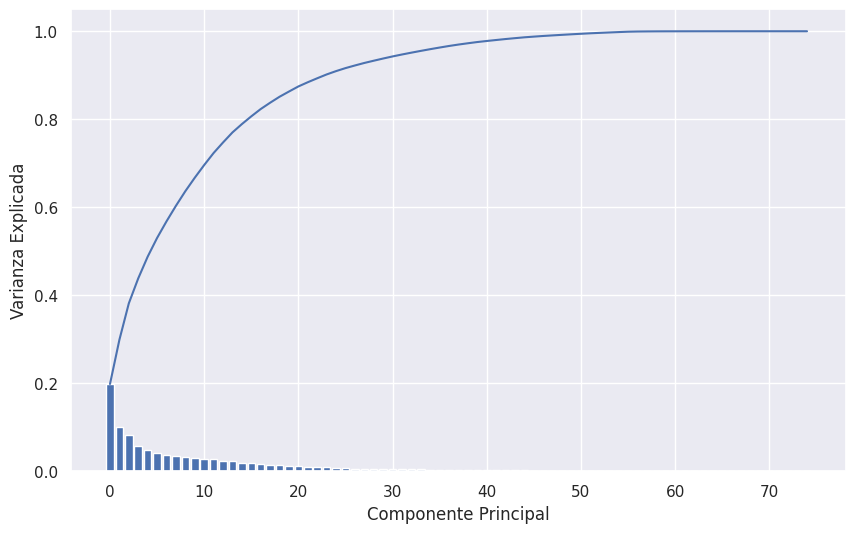

In [84]:
num_components = len(pca.explained_variance_ratio_) #almacena el número total de componentes principales generados por el modelo PCA
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()

In [85]:
pca = PCA(n_components=0.80)
pca.fit(X_norm)

PCA(n_components=0.8)

In [86]:
# Transformar todo el conjunto con el PCA entrenado
X_pca_full = pca.transform(scaler_X.transform(X))

In [87]:
# Reaplicar scaler_y a toda la y para mantener el shape
y_norm_full = scaler_y.transform(y)

 utiliza el Análisis de Componentes Principales **(PCA)** para reducir la dimensionalidad del conjunto de **datos X_norm**, seleccionando el número de componentes principales de tal manera que se explique al menos el 80% de la varianza total de los datos.

 Es una forma de decidir cuántos componentes principales retener basándose en la cantidad de información (varianza) que queremos preservar.

In [88]:
X_pca_full.shape

(35064, 16)

In [89]:
X_pca_df = pd.DataFrame(X_pca_full)  # Convert to DataFrame
X_pca_df.head()

0         1         2         3         4         5         6   \
0 -1.269661  0.349569  0.081263 -0.434084  0.209578 -0.112818  0.152948   
1 -1.520594  0.157066  0.063572 -0.403703  0.380247 -0.204399 -0.004992   
2 -1.523696  0.146738  0.042308 -0.428072  0.306985 -0.189871 -0.076850   
3 -1.546328  0.048295 -0.007223 -0.446778  0.290431 -0.187189 -0.079941   
4 -1.559520 -0.034872 -0.041907 -0.470265  0.268957 -0.194931 -0.078130   

         7         8         9         10        11        12        13  \
0 -0.696333 -0.493902  0.155187  0.793597  0.259373  0.353475 -0.211629   
1 -0.419144 -0.602737  0.099543  0.221132 -0.639540  0.539058 -0.414604   
2 -0.484971 -0.637139  0.154440  0.235340 -0.645598  0.499236 -0.418287   
3 -0.491083 -0.643442  0.146837  0.280706 -0.632268  0.496815 -0.435607   
4 -0.500768 -0.648891  0.138715  0.299795 -0.609973  0.496617 -0.442234   

         14        15  
0 -0.264541 -0.099279  
1 -0.018870 -0.192232  
2  0.018606 -0.203533  
3  0.027457 -0.183221  
4  0.024793 -0.170795

In [90]:
dataset_norm = np.concatenate((X_pca_full, y_norm_full), axis=1)# concatena dos Arrays. estás uniendo cada fila de X_pca con su respectivo valor de y_norm, hacia la derecha (axis=1), es decir, columna por columna.

past_history = 24   # Cuántos pasos pasados usas como entrada
future_target = 1   # Cuántos pasos en el futuro quieres predecir

In [91]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [92]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

In [93]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [94]:
batch_size = 32
buffer_size = 1000

In [95]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [96]:
# Definir algunos parametros comunes

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [97]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

# **4. PRONOSTICO DEL PRECIO DE LA ENERGIA ELECTRICA**

In [98]:
past_history = 24
future_target = 1

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

# Separar features y target del dataset_norm
features = dataset_norm[:, :-1]
target = dataset_norm[:, -1]

X, y = multivariate_data(features, target,
                         start_index=0,
                         end_index=None,
                         history_size=past_history,
                         target_size=future_target,
                         step=1,
                         single_step=True)

# Convertir X a forma 2D para modelo Dense
X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

# Separar en entrenamiento y validación
split = int(X.shape[0] * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [99]:
# Definir y entrenar el modelo Dense
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_schedule])

Epoch 1/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.3621 - root_mean_squared_error: 0.5810 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674 - learning_rate: 5.0000e-04
Epoch 2/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0444 - root_mean_squared_error: 0.2100 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516 - learning_rate: 5.0000e-04
Epoch 3/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417 - learning_rate: 5.0000e-04
Epoch 4/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710 - learning_rate: 5.0000e-04
Epoch 5/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435 - learning_rate: 5.0000e-04
Epoch 6/100
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.00

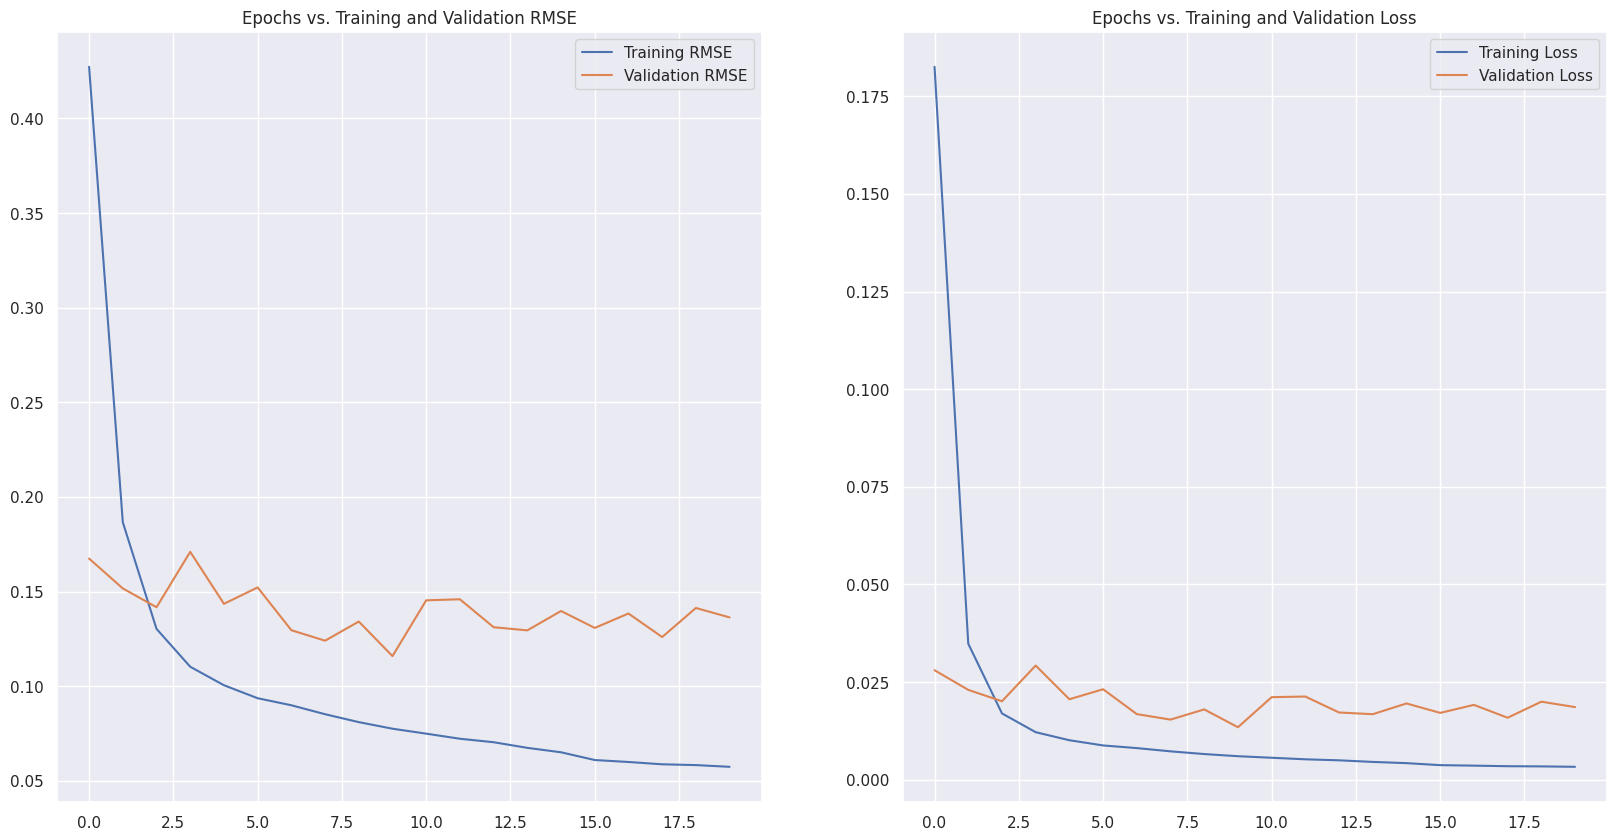

In [100]:
# Función para graficar las métricas de entrenamiento
def plot_model_rmse_and_loss(history):
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

plot_model_rmse_and_loss(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


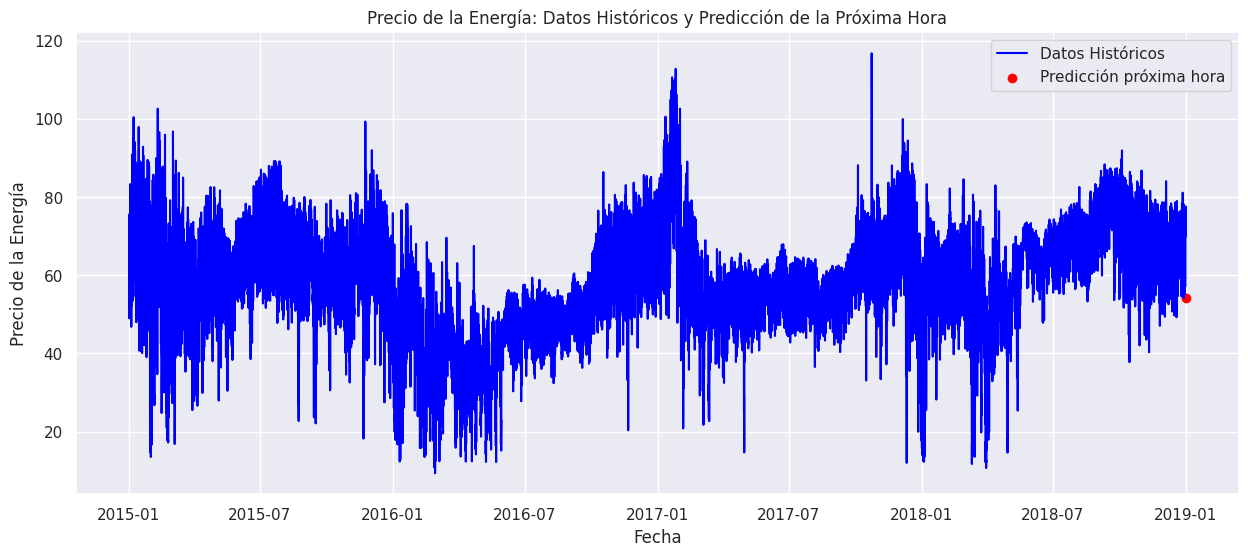

In [101]:
# Tomar la última ventana de 24 horas
last_window = dataset_norm[-past_history:, :-1]
last_window_input = last_window.reshape(1, -1)

# Predecir en forma normalizada
prediction_norm = model.predict(last_window_input)[0][0]

# Reescalar si hay scaler de y_norm
try:
    prediction_rescaled = scaler_y.inverse_transform([[prediction_norm]])[0][0]
except:
    prediction_rescaled = prediction_norm

# Crear fecha para la predicción
last_date = df_energy.index[-1]
future_date = last_date + pd.Timedelta(hours=1)

# Graficar resultados
plt.figure(figsize=(15, 6))
plt.plot(df_energy.index, df_energy['price actual'], label='Datos Históricos', color='blue')
plt.scatter([future_date], [prediction_rescaled], label='Predicción próxima hora', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio de la Energía')
plt.title('Precio de la Energía: Datos Históricos y Predicción de la Próxima Hora')
plt.legend()
plt.grid(True)
plt.show()


In [102]:
print(f"🔮 Predicción para la próxima hora: {prediction_rescaled:.2f}")


🔮 Predicción para la próxima hora: 54.24


🔮 Predicción para la próxima hora (2018-12-31 23:00:00+00:00): 54.24


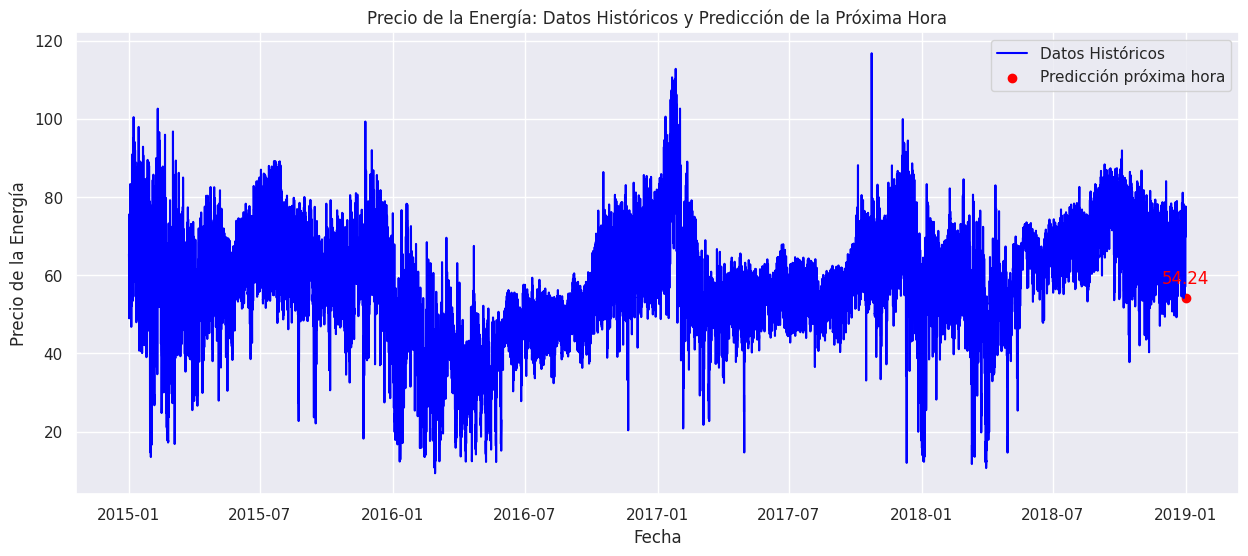

In [103]:
# Mostrar el valor predicho
print(f"🔮 Predicción para la próxima hora ({future_date}): {prediction_rescaled:.2f}")

# Gráfica con anotación del valor
plt.figure(figsize=(15, 6))
plt.plot(df_energy.index, df_energy['price actual'], label='Datos Históricos', color='blue')
plt.scatter([future_date], [prediction_rescaled], label='Predicción próxima hora', color='red')

# Añadir texto con el valor predicho
plt.annotate(f'{prediction_rescaled:.2f}',
             (future_date, prediction_rescaled),
             textcoords="offset points",
             xytext=(0,10), ha='center', fontsize=12, color='red')

plt.xlabel('Fecha')
plt.ylabel('Precio de la Energía')
plt.title('Precio de la Energía: Datos Históricos y Predicción de la Próxima Hora')
plt.legend()
plt.grid(True)
plt.show()


**HASTA AHORA CONSTRUIMOS UN DATASET PARA PRONOSTICAR EL PRECIO DE LA ENERGIA ELECTRICA EN 5 CIUDADES DEL PAIS, EL SIGUIENTE PASO ES USAR RNN PARA HACER DICHA PREDICCION.**


## **LSTM OPTIMIZADO**

## **XGBoost**


# **5. CODIGO LSTM (OPTIMIZADO)**

In [104]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import plot_model

In [105]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('-------')
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('-------')
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)

X_train:  (28031, 384)
y_train:  (28031,)
-------
X_test:  (3983, 24, 17)
y_test:  (3983, 1)
-------
X_val:  (7008, 384)
y_val:  (7008,)


### **5.1. MODELO:** Sin Optimizar LSTM

In [106]:
# --- 2. Preparación para LSTM ---
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data, labels = [], []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i + target_size - 1])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

past_history = 24
future_target = 1
features = dataset_norm[:, :-1]
target = dataset_norm[:, -1]

X, y = multivariate_data(features, target, 0, None, past_history, future_target, 1, True)

In [107]:
# División en entrenamiento y validación
split = int(X.shape[0] * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [109]:
window_size = 24

In [110]:
model1 = Sequential() # Secuencial significa que la Red Neuronal tiene varias capas
#model1.add(InputLayer((window_size, 1))) # Cual es el tamano de los datos de entrada
model1.add(InputLayer((window_size, 17))) # Cual es el tamano de los datos de entrada
model1.add(LSTM(64)) # Capa de tipo LSTM
model1.add(Dense(8, 'relu')) # Densa quiere decir que se conecten todas las neuronas y utilizamos una funcion de activacion tipo ReLu
model1.add(Dense(1, 'linear'))

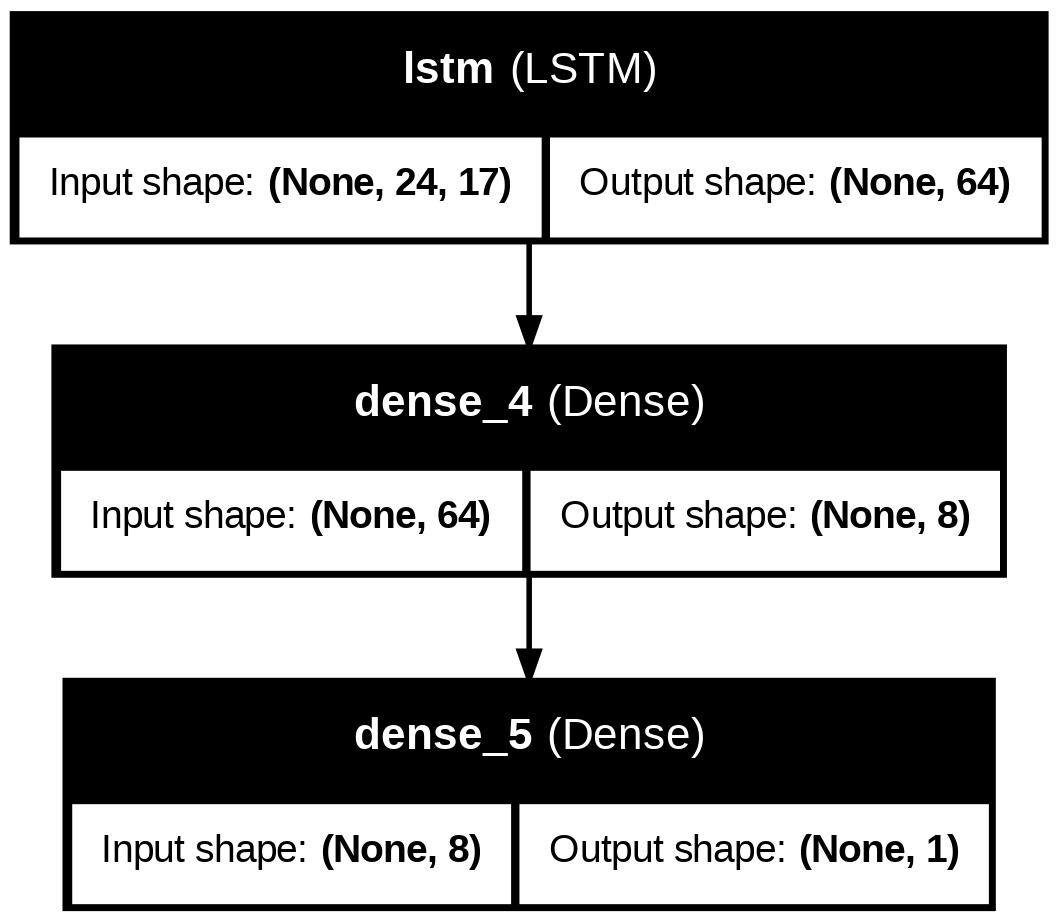

In [111]:
# Guardar la visualización del modelo
plot_model(model1, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

In [113]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,521 (84.07 KB)

 Trainable params: 21,521 (84.07 KB)

 Non-trainable params: 0 (0.00 B)

###**5.2. MODELO:** Optimizar LSTM

In [114]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, RNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import SVG

!pip install keras-tuner
import keras_tuner as kt

from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


<ipython-input-114-8db0c9f1ec08>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [115]:
# Define un objeto HyperParameters
hp = HyperParameters()

Crea un objeto vacío llamado **hp** que representa un conjunto de hiperparámetros que se van a probar durante la búsqueda (sintonizador) con Keras Tuner.

In [116]:
# Definir ventana
window_size = 24

In [117]:
def build_lstm_model(hp):
    modelop = Sequential()
    modelop.add(InputLayer((window_size, 16)))  # input_shape: (timesteps, features)

    modelop.add(LSTM(
        units=hp.Int('lstm_units', min_value=1, max_value=200, step=10),
        activation=hp.Choice('l_lstm_activation', values=['tanh', 'relu', 'sigmoid']),
        return_sequences=False
    ))

    modelop.add(Dense(
        units=hp.Int('dense_units', min_value=1, max_value=200, step=10),
        activation=hp.Choice('l_dense_activation', values=['tanh', 'relu', 'sigmoid'])
    ))

    modelop.add(Dense(1, activation='linear'))  # salida para regresión

    modelop.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mean_squared_error',
        metrics=['RootMeanSquaredError']
    )

    return modelop

In [118]:
print("Forma de X_train:", X_train.shape)

Forma de X_train: (28031, 24, 16)


In [119]:
# PREPARAR DATOS PARA LA LSTM. Asegurar que X_train esté en forma (samples, timesteps * features)
X_train_lstm = X_train.reshape((-1, 24, 16))
X_val_lstm = X_val.reshape((-1, 24, 16))
X_test_lstm = X_test  # ya está en forma (3984, 24, 17)
y_test = y_test.reshape(-1, 1)

In [120]:
# Crea el sintonizador Hyperband
sintonizador = Hyperband(
    build_lstm_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    hyperband_iterations=5,
    project_name='lstm_tuning'
)

In [121]:
# Configurar el callback de parada temprana para prevenir el sobreajuste
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

sintonizador.search(
    X_train_lstm, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
141               |141               |lstm_units
sigmoid           |sigmoid           |l_lstm_activation
1                 |1                 |dense_units
sigmoid           |sigmoid           |l_dense_activation
0.0030089         |0.0030089         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 90/701 ━━━━━━━━━━━━━━━━━━━━ 1:00 99ms/step - RootMeanSquaredError: 0.1401 - loss: 0.0204

KeyboardInterrupt: 

In [ ]:
# Obtiene la mejor configuración de hiperparámetros
best_hyperparameters = sintonizador.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Imprimir los mejores hiperparámetros
print("\n🔧 Mejores hiperparámetros encontrados:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

In [ ]:
# Construye y compila el modelo con los mejores hiperparámetros
best_model = build_lstm_model(best_hyperparameters)

In [ ]:
# visualizacion del mejor modelo
plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)
best_model.summary()

In [ ]:
# Guarda la visualización del modelo
keras.utils.plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)

###**5.4. MODELO:** FINAL LSTM + OPTIMIZADO

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

In [123]:
# --- 2. Preparación para LSTM ---
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data, labels = [], []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i + target_size - 1])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

past_history = 24
future_target = 1
features = dataset_norm[:, :-1]
target = dataset_norm[:, -1]

X, y = multivariate_data(features, target, 0, None, past_history, future_target, 1, True)

In [124]:
# División en entrenamiento y validación
split = int(X.shape[0] * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [125]:
# Arquitectura del modelo basada en el mejor tuner
window_size = 24
n_features = 16  # Confirmado tras PCA y dataset_norm

# Construir el modelo
model2 = Sequential()
model2.add(InputLayer((past_history, X.shape[2])))
model2.add(LSTM(128, activation='tanh', return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(LSTM(64, activation='tanh'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='linear'))

# Visualización del modelo
plot_model(model2, to_file='LSTM_model2_updated.png', show_shapes=True, show_layer_names=True)

# Resumen del modelo
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 24, 128)             │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,481 (486.25 KB)

 Trainable params: 124,097 (484.75 KB)

 Non-trainable params: 384 (1.50 KB)

### Compilación del modelo y entrenamiento:
Se compila el modelo definiendo la función de pérdida, el optimizador y las métricas. Luego se entrena el modelo utilizando los datos de entrenamiento y validación.

##**5.5. Compilacion del modelo**

In [126]:
# Compilación con tasa de aprendizaje ajustada
model2.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [127]:
cp2 = ModelCheckpoint(
    '/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/modelLSTMop.keras',
    save_best_only=True
)

In [128]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [129]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

cp2 = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/modelLSTMop.keras',
    save_best_only=True
)

##**5.6. ENTRENAMIENTO DEL MODELO**

In [130]:
# Obtener historial de entrenamiento del modelo
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[cp2, early_stopping, reduce_lr]
)

Epoch 1/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - loss: 1.3763 - root_mean_squared_error: 1.1657 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3341 - learning_rate: 1.0000e-04
Epoch 2/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - loss: 0.6174 - root_mean_squared_error: 0.7854 - val_loss: 0.0683 - val_root_mean_squared_error: 0.2614 - learning_rate: 1.0000e-04
Epoch 3/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 55s 63ms/step - loss: 0.3845 - root_mean_squared_error: 0.6194 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2168 - learning_rate: 1.0000e-04
Epoch 4/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - loss: 0.2321 - root_mean_squared_error: 0.4814 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775 - learning_rate: 1.0000e-04
Epoch 5/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - loss: 0.1334 - root_mean_squared_error: 0.3651 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781 - learning_rate: 1.0000e-04
Epoch 6/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - los

In [131]:
# Aqui guardamos el modelo como un archivo independiente

cp2 = ModelCheckpoint('/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/modelLSTMop.keras', save_best_only=True)

model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00013), metrics=[RootMeanSquaredError()])

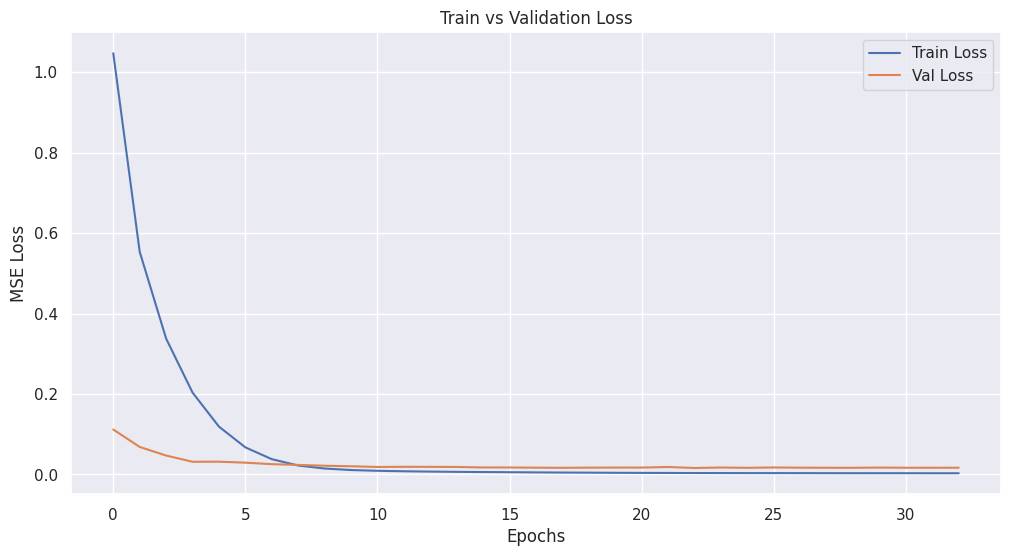

In [132]:
# Plot the loss history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()



### Carga del modelo guardado y predicción:
Finalmente, se carga el modelo guardado y se realizan las predicciones para los datos de entrenamiento, validación y prueba.

In [133]:
# Cargamos modelo

model2 = load_model('/content/drive/MyDrive/SENSORES REMOTOS/DATASETS/modelLSTMop.keras')

In [134]:
train_predictions = model2.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

876/876 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step


Train Predictions   Actuals
0               0.512548  0.508886
1               0.463909  0.457151
2               0.424850  0.422164
3               0.403593  0.424118
4               0.400389  0.406997
...                  ...       ...
28026           0.409691  0.186936
28027           0.433773  0.387271
28028           0.436502  0.468968
28029           0.420851  0.386713
28030           0.398606  0.340653

[28031 rows x 2 columns]

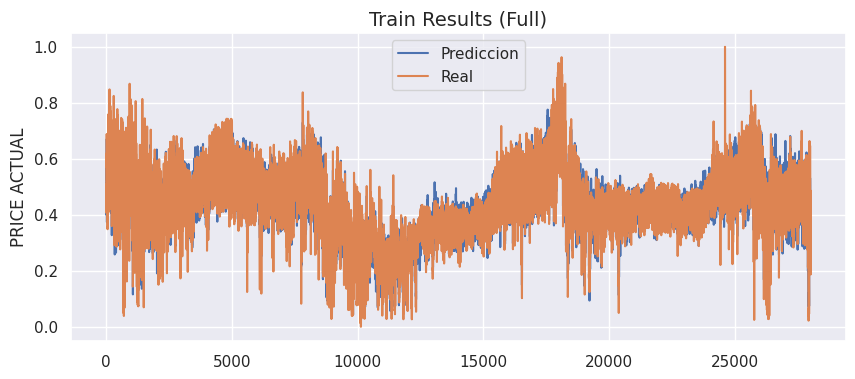

In [135]:
plt.figure(figsize = [10, 4])
plt.title('Train Results (Full)', fontsize = 14)
plt.plot(train_results['Train Predictions'], label = 'Prediccion')
plt.plot(train_results['Actuals'], label = 'Real')
plt.ylabel('PRICE ACTUAL')
plt.legend()

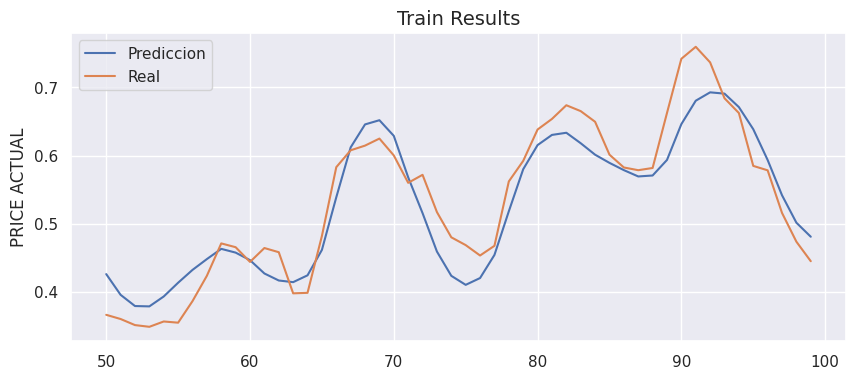

In [136]:
plt.figure(figsize = [10, 4])
plt.title('Train Results', fontsize = 14)
plt.plot(train_results['Train Predictions'][50:100], label = 'Prediccion')
plt.plot(train_results['Actuals'][50:100], label = 'Real')
plt.ylabel('PRICE ACTUAL')
plt.legend()

In [137]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(28031, 24, 16)
(7008, 24, 16)
(3983, 24, 17)


In [138]:
X, y = multivariate_data(features, target, 0, None, past_history, future_target, 1, True)

# División nuevamente
total_samples = X.shape[0]
train_size = int(total_samples * 0.8)
val_size = int(total_samples * 0.1)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


In [139]:
# Asegurar reshape de targets si es necesario
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Predicciones
train_predictions = model2.predict(X_train, verbose=0)
val_predictions = model2.predict(X_val, verbose=0)
test_predictions = model2.predict(X_test, verbose=0)

In [140]:
# Invertimos la escala de predicciones y valores reales
train_predictions_rescaled = scaler_y.inverse_transform(train_predictions)
val_predictions_rescaled = scaler_y.inverse_transform(val_predictions)
test_predictions_rescaled = scaler_y.inverse_transform(test_predictions)

y_train_rescaled = scaler_y.inverse_transform(y_train)
y_val_rescaled = scaler_y.inverse_transform(y_val)
y_test_rescaled = scaler_y.inverse_transform(y_test)

## **5.7. Prediccion**

Ahora podemos realizar la prediccion de las proximos 168 horas (una semana), utilizando el modelo:

In [141]:
# Ajustes específicos para multistep
future_target = 168  # 168 horas
past_history = 168 # usamos el comportamiento semanal. otros valores posibles 336 y 672

# Crear nuevos datos para entrenamiento multistep
X_seq, y_seq = multivariate_data(features, target, 0, None, past_history, future_target, step=1, single_step=False)

In [142]:
# División
total_seq = X_seq.shape[0]
train_size_seq = int(total_seq * 0.8)
val_size_seq = int(total_seq * 0.1)

X_train_seq = X_seq[:train_size_seq]
y_train_seq = y_seq[:train_size_seq]
X_val_seq = X_seq[train_size_seq:train_size_seq+val_size_seq]
y_val_seq = y_seq[train_size_seq:train_size_seq+val_size_seq]
X_test_seq = X_seq[train_size_seq+val_size_seq:]
y_test_seq = y_seq[train_size_seq+val_size_seq:]

In [143]:
# Modelo secuencial multistep (LSTM optimizada)
model_seq = Sequential()
model_seq.add(InputLayer((past_history, X.shape[2])))
model_seq.add(LSTM(128, activation='tanh', return_sequences=True))
model_seq.add(Dropout(0.2))
model_seq.add(LSTM(64, activation='tanh'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(future_target))

model_seq.compile(loss='mse', optimizer=Adam(0.0005), metrics=['mae'])

In [144]:
# Entrenamiento
history_seq = model_seq.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=6, restore_best_weights=True)]
)

Epoch 1/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 306s 346ms/step - loss: 0.0420 - mae: 0.1478 - val_loss: 0.0181 - val_mae: 0.1154
Epoch 2/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 318s 342ms/step - loss: 0.0097 - mae: 0.0759 - val_loss: 0.0180 - val_mae: 0.1160
Epoch 3/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 292s 336ms/step - loss: 0.0075 - mae: 0.0668 - val_loss: 0.0163 - val_mae: 0.1090
Epoch 4/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 302s 348ms/step - loss: 0.0058 - mae: 0.0588 - val_loss: 0.0155 - val_mae: 0.1062
Epoch 5/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 323s 350ms/step - loss: 0.0050 - mae: 0.0547 - val_loss: 0.0161 - val_mae: 0.1081
Epoch 6/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 308s 333ms/step - loss: 0.0044 - mae: 0.0510 - val_loss: 0.0158 - val_mae: 0.1070
Epoch 7/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 363s 380ms/step - loss: 0.0039 - mae: 0.0478 - val_loss: 0.0136 - val_mae: 0.0969
Epoch 8/50
869/869 ━━━━━━━━━━━━━━━━━━━━ 350s 343ms/step - loss: 0.0034 - mae: 0.0451 - val_loss: 0.0147 - val_mae: 0.1030
Epoch 9/50
869/869 ━━━━━

In [145]:
# Evaluación
predicted_seq = model_seq.predict(X_test_seq, verbose=0)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)
predicted_rescaled = scaler_y.inverse_transform(predicted_seq)

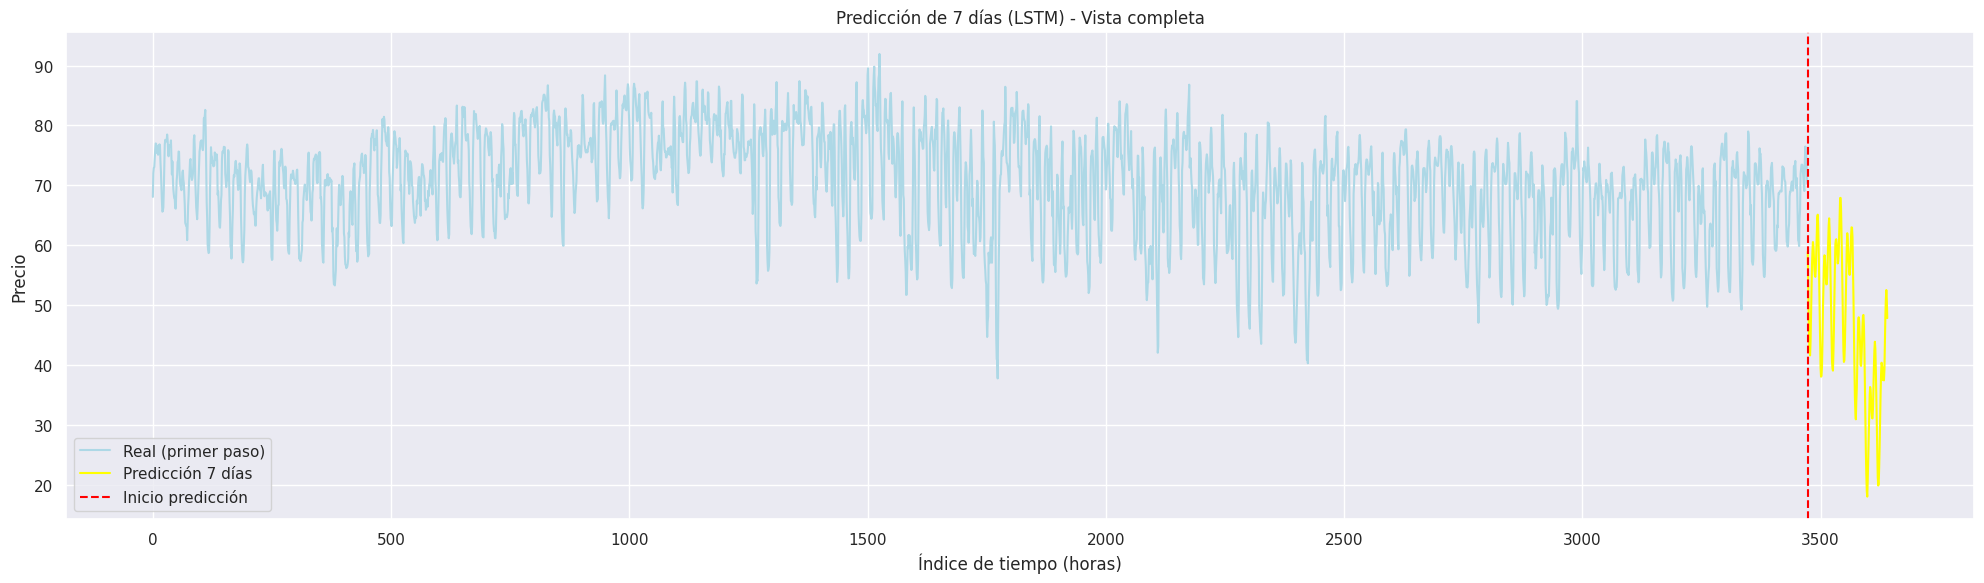

In [146]:
# Visualización: todos los valores + 168 pasos
full_plot_len = y_test_rescaled.shape[0]
pred_start_idx = full_plot_len - 1

plt.figure(figsize=(20,6))
plt.plot(np.arange(full_plot_len), y_test_rescaled[:, 0], label='Real (primer paso)', color='lightblue')
plt.plot(np.arange(pred_start_idx, pred_start_idx + future_target), predicted_rescaled[-1], label='Predicción 7 días', color='yellow')
plt.axvline(x=pred_start_idx, color='red', linestyle='--', label='Inicio predicción')
plt.title('Predicción de 7 días (LSTM) - Vista completa')
plt.xlabel('Índice de tiempo (horas)')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

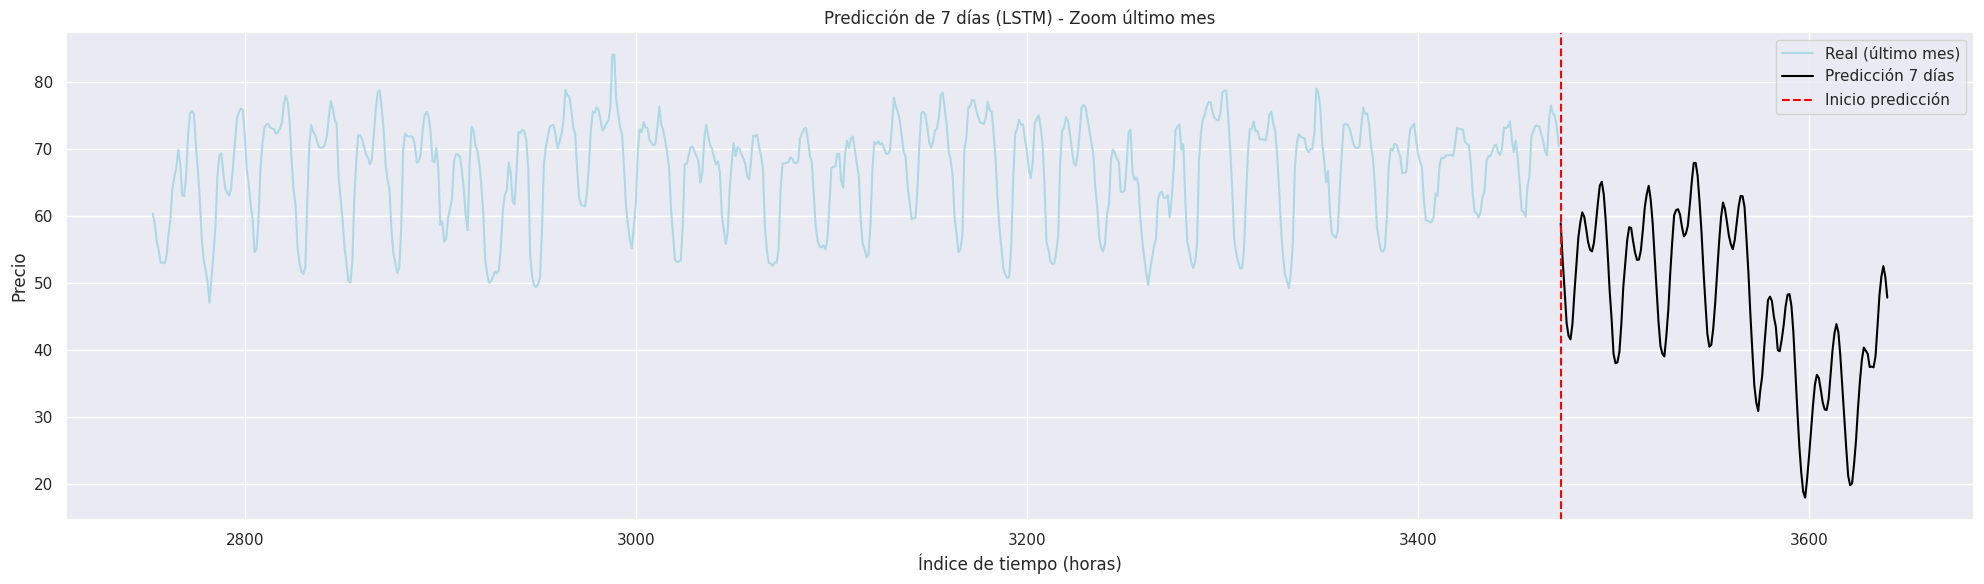

In [147]:
# Visualización: zoom último mes + predicción
zoom_len = 24 * 30  # Último mes
start_zoom = max(pred_start_idx - zoom_len, 0)

plt.figure(figsize=(20,6))
plt.plot(np.arange(start_zoom, pred_start_idx), y_test_rescaled[start_zoom:pred_start_idx, 0], label='Real (último mes)', color='lightblue')
plt.plot(np.arange(pred_start_idx, pred_start_idx + future_target), predicted_rescaled[-1], label='Predicción 7 días', color='black')
plt.axvline(x=pred_start_idx, color='red', linestyle='--', label='Inicio predicción')
plt.title('Predicción de 7 días (LSTM) - Zoom último mes')
plt.xlabel('Índice de tiempo (horas)')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Métricas promedio sobre todos los pasos
mse_multi = mean_squared_error(y_test_rescaled.flatten(), predicted_rescaled.flatten())
rmse_multi = np.sqrt(mse_multi)
mae_multi = mean_absolute_error(y_test_rescaled.flatten(), predicted_rescaled.flatten())
print(f"Multi-step RMSE: {rmse_multi:.4f}, MAE: {mae_multi:.4f}")

# **6. XGBoost**

**XGBoost (eXtreme Gradient Boosting)** es una biblioteca de software avanzada diseñada para la implementación eficiente de algoritmos de boosting de gradiente. Fue desarrollada por **Tianqi Chen** y es ampliamente utilizada en competiciones de ciencia de datos y en la industria para tareas de aprendizaje supervisado, como clasificación y regresión.

El **método XGBoost** es una extensión del algoritmo de boosting de gradiente. El boosting de gradiente es una técnica de aprendizaje automático que construye modelos predictivos en forma de un ensamble de modelos más simples, generalmente árboles de decisión. Funciona entrenando secuencialmente modelos para corregir los errores cometidos por los modelos anteriores y combinarlos de manera que se mejore la precisión de la predicción final.

Algunas de las características clave de XGBoost incluyen:

**Optimización del gradiente regularizado:** XGBoost introduce una regularización en la función de pérdida del boosting de gradiente, lo que ayuda a evitar el sobreajuste y mejora el rendimiento general del modelo.

**Manejo eficiente de datos dispersos:** XGBoost está optimizado para trabajar eficientemente con matrices dispersas, lo que es común en muchos problemas de ciencia de datos, como la clasificación de texto.

**Computación paralela y distribuida:** XGBoost puede aprovechar múltiples núcleos de CPU y máquinas distribuidas para acelerar el entrenamiento de modelos, lo que lo hace adecuado para conjuntos de datos grandes.

**Flexibilidad:** XGBoost permite a los usuarios definir objetivos de optimización personalizados y criterios de evaluación, lo que lo hace adaptable a una amplia gama de problemas de aprendizaje supervisado.

**Soporte para múltiples lenguajes de programación:** Aunque XGBoost se implementó originalmente en C++, tiene interfaces para Python, R, Java, Scala, y Julia, lo que facilita su integración en proyectos existentes.

In [ ]:
pip install xgboost

import xgboost as xgb

**Entrenamiento de datos**

In [ ]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

**Suposiciones iniciales sobre la forma de los datos:**

**X_train**, **X_val** y **X_test** son tensores con tres dimensiones, típicamente en la forma (samples, timesteps, features).

Este formato es común en datos de series temporales donde:

  **samples** representa el número de muestras de datos.

  **timesteps** representa la cantidad de pasos de tiempo observados.

  **features** representa el número de características o variables observadas en cada paso de tiempo.

Objetivo de **.reshape(-1, X_train.shape[1] * X_train.shape[2])**:

La función **.reshape()** cambia la estructura de los datos.

  -1 en el primer argumento permite que NumPy (o cualquier librería de matrices similar) determine automáticamente el número de filas necesario para mantener el mismo número total de elementos en el tensor.

  **X_train.shape[1] * X_train.shape[2]** multiplica el número de timesteps y features para obtener un solo valor, que se usa para reducir las dimensiones de X_train a una matriz bidimensional.

  Esto cambia el tensor tridimensional (samples, timesteps, features) a una matriz bidimensional de la forma (samples, timesteps * features).

**Resultado de cada línea:**

  Cada línea aplana las últimas dos dimensiones (timesteps y features) de X_train, X_val, y X_test en una sola dimensión.

  Así, el **modelo XGBoost** puede procesar estos datos en formato de tabla bidimensional (samples, timesteps * features).

En terminos de un ejemplo simple, supongamos que:

    X_train.shape es (100, 10, 5):
        100 muestras, 10 timesteps y 5 características.

Después de X_train.reshape(-1, X_train.shape[1] * X_train.shape[2]), la forma será (100, 50), ya que cada muestra ahora se representa con un solo vector de tamaño 10 * 5 = 50.

# PARAMETRIZAMOS

In [ ]:
param = {'eta': 0.03, 'max_depth': 180,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'verbosity': 0, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)

eval_list = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(param, dtrain, num_boost_round=180, evals=eval_list, early_stopping_rounds=5)

**Configuración de Parámetros**

    param = {'eta': 0.03, 'max_depth': 180,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

Aquí se establece un diccionario param con los hiperparámetros para el modelo XGBoost. Cada parámetro tiene un propósito específico:

  **eta:** La tasa de aprendizaje del modelo, que controla cuánto ajusta el modelo en cada iteración. Un valor bajo (0.03) ayuda a que el modelo aprenda más lentamente, reduciendo el riesgo de sobreajuste.

  **max_depth:** Profundidad máxima de cada árbol. Un valor alto (180) permite que el modelo capture relaciones complejas, aunque también puede aumentar el riesgo de sobreajuste.

  **subsample:** Proporción de datos usados en cada árbol. 1.0 significa que se utiliza el 100% de los datos.

  **colsample_bytree:** Proporción de características (columnas) usadas para construir cada árbol. 0.95 indica que el modelo usará el 95% de las características en cada iteración, ayudando a prevenir sobreajuste.

  **alpha y lambda:** Parámetros de regularización L1 (alpha) y L2 (lambda), que ayudan a reducir el sobreajuste penalizando valores grandes de los pesos del modelo.

  **gamma:** Parámetro de reducción de pérdida, que controla cuándo dividir un nodo. Si el valor de ganancia es menor que gamma, el nodo no se divide. Un valor bajo (0.1) permite más divisiones.

  **objective:** La función objetivo. En este caso, 'reg:linear' indica una tarea de regresión.

  **eval_metric:** Métrica para evaluar el modelo. 'rmse' (Root Mean Square Error) es una métrica común en problemas de regresión.

  **silent:** Configurado en 1, para evitar que se impriman mensajes de salida durante el entrenamiento.

  **min_child_weight:** Peso mínimo para dividir un nodo, lo que ayuda a prevenir divisiones en nodos con poca información.

  **n_jobs:** Número de núcleos de CPU a usar. -1 indica que usará todos los núcleos disponibles para acelerar el entrenamiento.

**Conversión de Datos con DMatrix**



*   dtrain = xgb.DMatrix(X_train_xgb, y_train)
*   dval = xgb.DMatrix(X_val_xgb, y_val)
*   dtest = xgb.DMatrix(X_test_xgb, y_test)


xgb.DMatrix convierte los datos en una estructura de datos optimizada que XGBoost usa para entrenar el modelo. Aquí se crean tres matrices:

    dtrain: Matriz para el conjunto de entrenamiento, formada por X_train_xgb y y_train.
    dval: Matriz para el conjunto de validación, formada por X_val_xgb y y_val.
    dtest: Matriz para el conjunto de prueba, formada por X_test_xgb y y_test.

Finalmente,

**eval_list** es una lista de tuplas que le indica a XGBoost qué conjuntos de datos monitorear durante el entrenamiento.

**Entrenamiento del Modelo**

    xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

**xgb.train():** Función para entrenar el modelo XGBoost con los siguientes parámetros:

  **param:** Los hiperparámetros definidos anteriormente.

  **dtrain:** El conjunto de datos de entrenamiento en formato DMatrix.

  **180:** Número máximo de rondas de entrenamiento.

  **eval_list:** Lista de evaluación para monitorear las métricas en los conjuntos de entrenamiento y validación.

  **early_stopping_rounds=3:** El entrenamiento se detiene automáticamente si la métrica de evaluación en el conjunto de validación no mejora en 3 rondas consecutivas, lo que ayuda a prevenir sobreajuste.

#Esta línea devuelve el modelo entrenado, almacenado en xgb_model, listo para ser evaluado o usado para hacer predicciones.

In [ ]:
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
xgb_forecast = xgb_model.predict(dtest).reshape(-1, 1)
xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

# Métricas de evaluación
rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print(f'RMSE del forecast XGBoost (una hora adelante): {rmse_xgb:.3f}')

Este bloque de código transforma las predicciones a su escala original, evalúa su precisión usando el RMSE y luego imprime este resultado. Esto ayuda a interpretar cuán bien predice el modelo XGBoost en términos de la métrica de error RMSE, que en este caso se usa para medir la precisión en la predicción del precio de la electricidad.

In [ ]:
# Visualización de las primeras 100 predicciones
index_range = range(100)
plt.figure(figsize=(10, 6))
plt.plot(index_range, y_test_inv[index_range], label='Valores Reales', marker='.', color='blue')
plt.plot(index_range, xgb_forecast_inv[index_range], label='Predicciones XGBoost', marker='x', color='red')
plt.title('Valores Reales vs Predicciones XGBoost (100 primeros)')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

#**Analisis del resultado**

**RMSE of hour-ahead electricity price XGBoost forecast: 2.222:** Indica que el error promedio de las predicciones del modelo, en términos de la diferencia entre los precios reales de la electricidad y los precios pronosticados por el modelo para una hora adelante, es de 2.222 unidades de la variable objetivo (por ejemplo, euros por megavatio-hora si se trata de precios de electricidad). Un RMSE de 2.222 sugiere que, en promedio, las predicciones del modelo se desvían en 2.222 unidades del valor real.

In [ ]:
# Predicciones futuras (100 pasos)
last_date = df_final['time'].max()
future_dates = [last_date + pd.Timedelta(hours=i) for i in range(1, 101)]

predictions_df = pd.DataFrame({
    'DATETIME': future_dates,
    'Predicted_Price': xgb_forecast_inv.flatten()[:100]
})

plt.figure(figsize=(15, 6))
plt.plot(df_final['time'], df_final['price actual'], label='Histórico Precio', color='blue')
plt.plot(predictions_df['DATETIME'], predictions_df['Predicted_Price'], label='Predicción (100 horas)', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio Real vs Predicción XGBoost para las próximas 100 horas')
plt.legend()
plt.grid(True)
plt.show()

## **6.1. Opcion 2 XGBoost para predecir una semana (168 pasos)

In [ ]:
# Flatten input for XGBoost (tabular format)
X_train_xgb = X_train_seq.reshape(-1, past_history * X_train_seq.shape[2])
X_val_xgb = X_val_seq.reshape(-1, past_history * X_val_seq.shape[2])
X_test_xgb = X_test_seq.reshape(-1, past_history * X_test_seq.shape[2])

# Flatten targets (each row is 168-step ahead targets)
y_train_xgb = y_train_seq
y_val_xgb = y_val_seq
y_test_xgb = y_test_seq

In [ ]:
# Entrenamos un modelo por cada paso futuro (1 a 168)
xgb_models = []
xgb_preds = []

for i in range(future_target):
    dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb[:, i])
    dval = xgb.DMatrix(X_val_xgb, label=y_val_xgb[:, i])
    dtest = xgb.DMatrix(X_test_xgb)

    param = {
        'eta': 0.03, 'max_depth': 8,
        'subsample': 0.8, 'colsample_bytree': 0.8,
        'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
        'objective': 'reg:squarederror', 'eval_metric': 'rmse',
        'n_jobs': -1, 'verbosity': 0
    }

    eval_list = [(dtrain, 'train'), (dval, 'eval')]

    model = xgb.train(param, dtrain, num_boost_round=250, evals=eval_list, early_stopping_rounds=10, verbose_eval=False)
    preds = model.predict(dtest)

    xgb_models.append(model)
    xgb_preds.append(preds)

In [ ]:
# Convertir predicciones a array 2D: (n_samples, 168)
xgb_preds = np.stack(xgb_preds, axis=1)

# Invertir la escala
xgb_preds_inv = scaler_y.inverse_transform(xgb_preds)
y_test_inv = scaler_y.inverse_transform(y_test_xgb)

In [ ]:
# Métricas
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), xgb_preds_inv.flatten()))
mae = mean_absolute_error(y_test_inv.flatten(), xgb_preds_inv.flatten())
print(f"XGBoost Multistep RMSE: {rmse:.4f}, MAE: {mae:.4f}")

In [ ]:
# --- Gráfico completo ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv[0], label='Real', color='lightblue', linewidth=2)
plt.plot(xgb_preds_inv[0], label='Predicción XGBoost (168 pasos)', color='black', linestyle='--', linewidth=2)
plt.title('Predicción XGBoost - Primer ejemplo multistep')
plt.xlabel('Horas Futuras')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Gráfico con zoom en el último mes (si disponible) ---
hist_len = 720  # 30 días

plt.figure(figsize=(14, 6))
plt.plot(range(hist_len), y_test_inv[0][-hist_len:], label='Histórico reciente', color='lightgray')
plt.plot(range(hist_len, hist_len + future_target), xgb_preds_inv[0], label='Predicción', color='black')
plt.title('Zoom: Histórico reciente + 7 días predicción XGBoost')
plt.xlabel('Horas')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **7. CONCLUSIONES**

📐 **1. Estructura de Entrada para los Modelos**

  Redes Densas (Fully Connected / Dense):


*   Requieren datos de entrada en 2 dimensiones, de la forma (batch_size, features).
*   Se debe a que las neuronas en estas redes no consideran la secuencia ni el orden temporal.

Ejemplo

        X_dense = X.reshape(-1, past_history * num_features)  # (batch_size, time_steps * features)\


Redes LSTM (Long Short-Term Memory):

     
*   Requieren entrada en 3 dimensiones, de la forma (batch_size, time_steps, features).
*   Esto se debe a que las LSTM procesan datos secuenciales donde el orden y la temporalidad son importantes.

Ejemplo:

    X_lstm = X.reshape(-1, past_history, num_features)


XGBoost:

*   Similar a redes densas, requiere entrada en 2D: (batch_size, features).
*   No procesa secuencias explícitamente, así que toda la información temporal debe codificarse en los features.    

**🚀 2. Tips de Rendimiento por Modelo**

  **LSTM:** Ideal para capturar patrones temporales y dependencias a largo plazo. Aporta buenos resultados si hay estacionalidad u horario como en series de consumo energético. Sensible a la escala, ¡usa siempre normalización!

  **Dense (autoregressive):** Aunque más simple, puede ofrecer buena precisión para predicción unipaso, pero no modela secuencias. Menos costosa computacionalmente.

  **XGBoost:** Poderoso en datos tabulares. Muy eficiente, tolerante a features no lineales y a la multicolinealidad. No necesita mucha ingeniería de features, pero sí un buen diseño del dataset.

**💡 Recomendaciones Finales**

  No mezcles estructuras de entrada: Cambiar de una capa LSTM a Dense requiere transformar el dataset de 3D a 2D, y viceversa. Asegúrate siempre de revisar el Input Shape del modelo antes de hacer .fit() o .predict().

  Explora la predicción directa multistep: Para evitar errores acumulativos de métodos autoregresivos, utiliza arquitecturas que predigan múltiples pasos simultáneamente (como hicimos en LSTM y XGBoost multistep).

  Visualiza tus datos siempre: Las gráficas de predicción frente a valores reales (con y sin zoom) ayudan a identificar patrones estacionales, anomalías y sobreajuste.

  Guarda e interpreta las métricas con contexto: RMSE y MAE son útiles, pero siempre observa la escala de tus datos. Un RMSE de 5 puede ser excelente o terrible, según el rango de precios.